In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[1])
sns.set_style(styles[2])

In [3]:
cd /home/chenxupeng/projects/training

/home/chenxupeng/projects/training


In [4]:
ls /Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/

exoRBase/                       hccpeak_removed/
GSE71008/                       piranha_peaks/
hccfull_ref_normalization/      piranha_peaks_iterative/
hccfull_removed/                scirep_ref_normalization/
hccpeakiter_ref_normalization/  scirep_removed/
hccpeakiter_removed/            transcripts_exrna/
hccpeak_ref_normalization/


In [5]:
root_path_full_removed = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/'
root_path_full_ref = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_ref_normalization/'
root_path_peak_removed = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_removed/'
root_path_peak_ref = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_ref_normalization/'
root_path_peakiter_removed ='/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_removed/'
root_path_peakiter_ref = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_ref_normalization/'
root_path_scirep_removed ='/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_removed/'
root_path_scirep_ref = '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_ref_normalization/'

In [7]:
ls /Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/Normal-HCC/logistic_regression.10.robust.stratified_shuffle_split

best_model.pkl                          features.txt
evaluation.stratified_shuffle_split.h5  metrics.stratified_shuffle_split.txt
feature_importances.txt


In [8]:
hccpath = 'Normal-HCC/'
stagepath='Normal-stage_A/'
crcpath = 'Normal-CRC/'

In [9]:
root_path = [root_path_full_removed ,root_path_full_ref ,root_path_peak_removed ,root_path_peak_ref ,
             root_path_peakiter_removed ,root_path_peakiter_ref,root_path_scirep_removed ,root_path_scirep_ref]
sample_path = [hccpath,stagepath,crcpath]

### plot AUC：
- probability
    - for leave one out, each row is one round, only one sample is test sample, merge all to plot one(43 sample in one curver)
    - for shuffle, each row is one round, several samples are selected as test samples, one row can be plotted as one curve. only plot one curve with CI is enough.
- sample label
    file:
    
- CI
- some statistics: 
    - annotate spe and sen point!
    - for CI, annotate three

In [10]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
def get_probs_split(root_path,samplepath,filename,interpolatednum=50,confidence=0.95):
    '''
    get probs from split
    use interpolation to calculate CI
    '''
    xvals = np.linspace(0, 1, interpolatednum)
    with h5py.File(root_path+samplepath+filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        #print (list(f.keys()))
        label = f['labels'][:]
    probs,labels,interpolatedvalue = {},{},{}
    for i in range(predictions.shape[0]):
        probs[i] = predictions[i][~train_index[i]]
        labels[i] = label[~train_index[i]]
        interpolatedvalue[i] = np.interp(xvals,plot_roc( probs[i],labels[i])[1],plot_roc( probs[i],labels[i])[2] )
    interarray = np.array([interpolatedvalue[i]  for i in range(predictions.shape[0])])
    mean,minimum,maximum = np.ndarray([interpolatednum]),np.ndarray([interpolatednum]),np.ndarray([interpolatednum])
    for i in range(interpolatednum):
        mean[i],minimum[i],maximum[i] = mean_confidence_interval(interarray[:,i],confidence)
    return np.concatenate((np.zeros(1),mean,np.ones(1))),np.concatenate((np.zeros(1),minimum,np.ones(1))),\
np.concatenate((np.zeros(1),maximum,np.ones(1))),interpolatednum+2
def plot_roc(prob,label):
    fpr, tpr, _ = roc_curve(label, prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return roc_auc,fpr, tpr

In [11]:
def find_metrics_best(label,expressionlevel):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = 1 - a
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    #print ("AUC:" +str(auc)) 
    thres = int(label.shape[0]/10.) if int(label.shape[0]/10.)>0 else 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres],np.argsort(-mcc_mean)[:thres],np.argsort(-F1_score)[:thres])),return_counts=True)
    print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
    
    
def find_metrics_best_for_shuffle(fpr,tpr):
    '''
    used for shuffle roc plot
    '''
    a = 1 - fpr 
    b = tpr
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = a
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    auc = sklearn.metrics.auc(a,b)
    #print ("AUC:" +str(auc)) 
    thres = 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres])),return_counts=True)
    #print (Sensitivity[uni[np.where(counts ==np.max(counts))][0]])
    #print (Specificity[uni[np.where(counts ==np.max(counts))][0]])
    #print (F1_score)
    #print (np.argsort(-F1_score))
    #print (uni,counts)
    print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]

In [12]:
def plot_jack(root_path,samplepath,filename,savepath,show_metrics=True,savefigure=False,title=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.ranking.leave_one_out/evaluation.leave_one_out.h5'
    '''
    with h5py.File(root_path+samplepath+filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        label = f['labels'][:]
    prob = predictions[~train_index]
    

    roc,fpr,tpr= plot_roc(prob,label)
        
    auc,sen,spe = find_metrics_best(label,prob)
    label2 = 'AUC: ' + str('%0.4s'%auc) +' ['+str('%0.4s'%spe)+' '+str('%0.4s'%sen)+']'
    #print (sen,spe)
    fig,ax=plt.subplots(1,figsize=(12,12))
    if show_metrics:
        ax.plot(fpr,tpr,linewidth=2,color='b',label='AUC: '+str(np.round(auc,3)))
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen-0.1),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
    else:
        ax.plot(fpr,tpr,linewidth=3,color='r',label='AUC: '+str(roc))
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [13]:
def plot_shuffle(root_path,samplepath,filename,savepath,show_metrics=True,savefigure=False,title=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5'
    '''
    mean,minimum,maximum,interpolatednum = get_probs_split(root_path,samplepath,filename)
    fig,ax=plt.subplots(1,figsize=(12,12))
    xvals = np.linspace(0, 1, interpolatednum)
    #print (interpolatednum)
    fill_between(xvals,minimum,maximum,where=(minimum<=maximum),color='b',alpha=0.1)
    
    auc,sen,spe = find_metrics_best_for_shuffle(xvals,mean) #tpr,1-fpr
    #label2 = 'AUC: ' + str('%0.4s'%auc) +' ['+str('%0.4s'%spe)+' '+str('%0.4s'%sen)+']'
    #print (sen,spe)
    # calculate min and max's corresponding tpr
    #print (1-spe,1./(interpolatednum-2))
    numind = np.ceil((1-spe)/(1./(interpolatednum-2))).astype('int')
    #print (numind)
    ax.plot(xvals,mean,linewidth=1,color='b',label='AUC: '+str(np.round(auc,3)))
    ax.plot(xvals,minimum,linewidth=1,color='b')
    ax.plot(xvals,maximum,linewidth=1,color='b')
    if show_metrics:
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen),
            arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
            )
        #ax.annotate('TPR '+str('%0.4s'%minimum[numind]), xy=( 1-spe,minimum[numind]), xytext=(1-spe+0.1, minimum[numind]),
            #arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
           # )
        #ax.annotate('TPR '+str('%0.4s'%maximum[numind]), xy=( 1-spe,maximum[numind]), xytext=(1-spe+0.1, maximum[numind]),
           # arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
           # )
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [14]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[2])
sns.set_style(styles[2])

In [15]:
def get_auc_stats(root_path,sample_path=hccpath):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'shuffle_split':
                auc_metrics_split[i] = h5py.File(root_path+sample_path+i+'/evaluation.shuffle_split.h5')
            else:
                with h5py.File(root_path+sample_path+i+'/evaluation.leave_one_out.h5','r') as f:
                    predictions =  f['predictions'][:]
                    train_index =  f['train_index'][:]
                    auc_metrics_jack[i]  = predictions[~train_index]
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))
    return auc_metrics_jack,auc_metrics_split

In [23]:
def plot_auc_stats(root_path,sample_path=hccpath):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    print (root_path+sample_path)
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'stratified_shuffle_split':
                plot_shuffle(root_path,sample_path,i+'/evaluation.stratified_shuffle_split.h5',
                             savepath='data/rocplot/'+root_path.split('/')[-2]+'/'+sample_path+'/'+i+'.png',show_metrics=True,savefigure=True,title=i+ ' ROC')
                
            else:
                plot_jack(root_path,sample_path,i+'/evaluation.leave_one_out.h5',
                         savepath='data/rocplot/'+root_path.split('/')[-2]+'/'+sample_path+'/'+i+'.png',show_metrics=True,savefigure=True,title=i+ ' ROC')
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))

plot_shuffle(root_path_full,hccpath,'random_forest.30.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5',
                             savepath='data/rocplot/'+root_path_full.split('/')[-2]+'/'+hccpath+'random_forest.30.robust.stratified_shuffle_split'+'.png',
             show_metrics=True,savefigure=True,title='random_forest.30.robust.stratified_shuffle_split ROC')

In [16]:
sample_path

['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/']

In [21]:
root_path[0:6]

['/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_ref_normalization/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_ref_normalization/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_ref_normalization/']

In [ ]:
# root_path[0:6] sample_path[0:2]
# root_path[6:8] sample_path[2:3]

In [24]:
for i in root_path[0:6]:
    for j in np.array(sample_path)[0:2]:
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]):
            os.mkdir('data/rocplot/'+i.split('/')[-2])
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/rocplot/'+i.split('/')[-2]+'/'+j)
        print (i)
        plot_auc_stats(root_path=i,sample_path=j)

/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/
/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/Normal-HCC/
logistic_regression.6.robust.stratified_shuffle_split  file found
3
logistic_regression.20.robust.stratified_shuffle_split  file found
3
logistic_regression.9.robust.stratified_shuffle_split  file found
3
random_forest.9.robust.stratified_shuffle_split  file found
3
logistic_regression.4.robust.stratified_shuffle_split  file found
3
random_forest.50.robust.stratified_shuffle_split  file found
2
logistic_regression.1.robust.stratified_shuffle_split  file found
3
random_forest.4.robust.stratified_shuffle_split  file found
3
logistic_regression.40.robust.stratified_shuffle_split  file found
3
random_forest.6.robust.stratified_shuffle_split  file found
3
random_forest.8.robust.stratified_shuffle_split  file found
3
random_forest.10.robust.stratified_shuffle_split  file found
3
logistic_regression.8.robust.

2
logistic_regression.20.robust.stratified_shuffle_split  file found
2
logistic_regression.9.robust.stratified_shuffle_split  file found
3
random_forest.9.robust.stratified_shuffle_split  file found
3
logistic_regression.4.robust.stratified_shuffle_split  file found
3
random_forest.50.robust.stratified_shuffle_split  file found
3
logistic_regression.1.robust.stratified_shuffle_split  file found
2
random_forest.4.robust.stratified_shuffle_split  file found
3
logistic_regression.40.robust.stratified_shuffle_split  file found
3
random_forest.6.robust.stratified_shuffle_split  file found
3
random_forest.8.robust.stratified_shuffle_split  file found
3
random_forest.10.robust.stratified_shuffle_split  file found
3
logistic_regression.8.robust.stratified_shuffle_split  file found
3
random_forest.20.robust.stratified_shuffle_split  file found
3
logistic_regression.30.robust.stratified_shuffle_split  file found
3
logistic_regression.50.robust.stratified_shuffle_split  file found
3
logistic_regr

2
logistic_regression.9.robust.stratified_shuffle_split  file found
3
random_forest.9.robust.stratified_shuffle_split  file found
3
logistic_regression.4.robust.stratified_shuffle_split  file found
2
random_forest.50.robust.stratified_shuffle_split  file found
3
logistic_regression.1.robust.stratified_shuffle_split  file found
2
random_forest.4.robust.stratified_shuffle_split  file found
3
logistic_regression.40.robust.stratified_shuffle_split  file found
3
random_forest.6.robust.stratified_shuffle_split  file found
3
random_forest.8.robust.stratified_shuffle_split  file found
3
random_forest.10.robust.stratified_shuffle_split  file found
3
logistic_regression.8.robust.stratified_shuffle_split  file found
3
random_forest.20.robust.stratified_shuffle_split  file found
3
logistic_regression.30.robust.stratified_shuffle_split  file found
3
logistic_regression.50.robust.stratified_shuffle_split  file found
3
logistic_regression.5.robust.stratified_shuffle_split  file found
3
random_forest.

In [25]:
for i in root_path[6:8]:
    for j in sample_path[2:3]:
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]):
            os.mkdir('data/rocplot/'+i.split('/')[-2])
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/rocplot/'+i.split('/')[-2]+'/'+j)
        print (i)
        plot_auc_stats(root_path=i,sample_path=j)

/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_removed/
/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_removed/Normal-CRC/
logistic_regression.6.robust.stratified_shuffle_split  file found
1
logistic_regression.20.robust.stratified_shuffle_split  file found
3
logistic_regression.9.robust.stratified_shuffle_split  file found
3
random_forest.9.robust.stratified_shuffle_split  file found
3
logistic_regression.4.robust.stratified_shuffle_split  file found
1
random_forest.50.robust.stratified_shuffle_split  file found
2
logistic_regression.1.robust.stratified_shuffle_split  file found
2
random_forest.4.robust.stratified_shuffle_split  file found
3
logistic_regression.40.robust.stratified_shuffle_split  file found
2
random_forest.6.robust.stratified_shuffle_split  file found
2
random_forest.8.robust.stratified_shuffle_split  file found
2
random_forest.10.robust.stratified_shuffle_split  file found
1
logistic_regression.8.robust.st

## 绘制clustermap

In [26]:
import pandas as pd

In [ ]:
features = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/piranha_peaks/Normal-HCC/logistic_regression.50.rfe.leave_one_out/features.txt', header=None).iloc[:, 0]
m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/piranha_peaks.txt', index_col=0)
m.loc[features]

In [29]:
root_path_full_ref.split('/')[-2],root_path_full_removed.split('/')[-2]

('hccfull_ref_normalization', 'hccfull_removed')

In [70]:
samples = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.piranha_peaks.txt', header=None)
samples_GSE = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.GSE71008.txt', header=None)
def clustermap_hcc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-HCC/'+filename+'/features.txt', header=None).iloc[:, 0]
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    cpmtable= m.loc[features,samples.iloc[:,0]]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',samples.shape[0])
    rgblabel[np.where(samples.iloc[:,1]=='Normal')] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_stage_A(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-stage_A/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples[samples[1]=='stage_A'][0],samples[samples[1]=='Normal'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',29)
    rgblabel[16:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_crc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-CRC/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))
    end = root_path.split('/')[-2]# GSE71008
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.log2(np.array(cpmtable)+1)
    nanind = np.where(np.isnan(cpmmatrix)==True)[1][0]
    cpmtable  = cpmtable.iloc[:,np.delete(np.arange(0,cpmmatrix.shape[1]),nanind)]
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix[:,np.delete(np.arange(0,cpmmatrix.shape[1]),nanind)].T).T
    #100,  50,   6,  36  =192
    #delete one sample 
    rgblabel = np.repeat('r',191)
    rgblabel[100:150] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(80,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_exo_hcc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-HCC/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_exo[samples_exo[1]=='HCC'][0],samples_exo[samples_exo[1]=='Healthy'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',53)
    rgblabel[21:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_exo_paad(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-PAAD/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_exo[samples_exo[1]=='PAAD'][0],samples_exo[samples_exo[1]=='Healthy'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',46)
    rgblabel[14:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [31]:
gsecount = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/count_matrix/GSE71008.txt')

In [32]:
gsecount.shape

(89619, 193)

In [33]:
gsecount.head()

,transcript,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,...,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
0,ENST00000473358.1|MIR1302-2HG-202|1544,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENST00000469289.1|MIR1302-2HG-201|843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENST00000466430.5|AL627309.1-201|31638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,ENST00000471248.1|AL627309.1-203|18221,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENST00000610542.1|AL627309.1-205|12999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
samples_GSE = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.GSE71008.txt', header=None)
sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))

In [35]:
sampless[1:].shape

(149,)

In [36]:
gsecount[sampless].shape

(89619, 150)

In [695]:
binlabel = np.repeat('stageA',29)
binlabel[16:] = 'Normal'
pd.DataFrame(np.concatenate((binlabel.reshape(-1,1),rgblabel.reshape(-1,1)),axis=1))

In [37]:
root_path

['/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_ref_normalization/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_ref_normalization/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_ref_normalization/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_removed/',
 '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_ref_normalization/']

In [38]:
def plot_cluster(root_path,sample_path):
    '''
    sample_path:hccpath,stagepath
    '''
    for i in os.listdir(root_path+sample_path):
        print (i)
        try:
            print (i, ' file found')
            print ('data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png')
            if sample_path == hccpath:
                print ('true')
                if root_path =='/home/chenxupeng/projects/training/data/exoRBase/':
                    clustermap_exo_hcc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
                else:
                    clustermap_hcc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path ==stagepath:
                clustermap_stage_A(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path ==crcpath:
                clustermap_crc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path == paadpath:
                clustermap_exo_paad(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))

In [ ]:
for i in root_path[:3]:
    for j in sample_path[:2]:
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

In [262]:
sample_path

['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/', 'Normal-PAAD/']

In [245]:
root_path[3:4],sample_path[2:3]

(['/home/chenxupeng/projects/training/data/GSE71008/'], ['Normal-CRC/'])

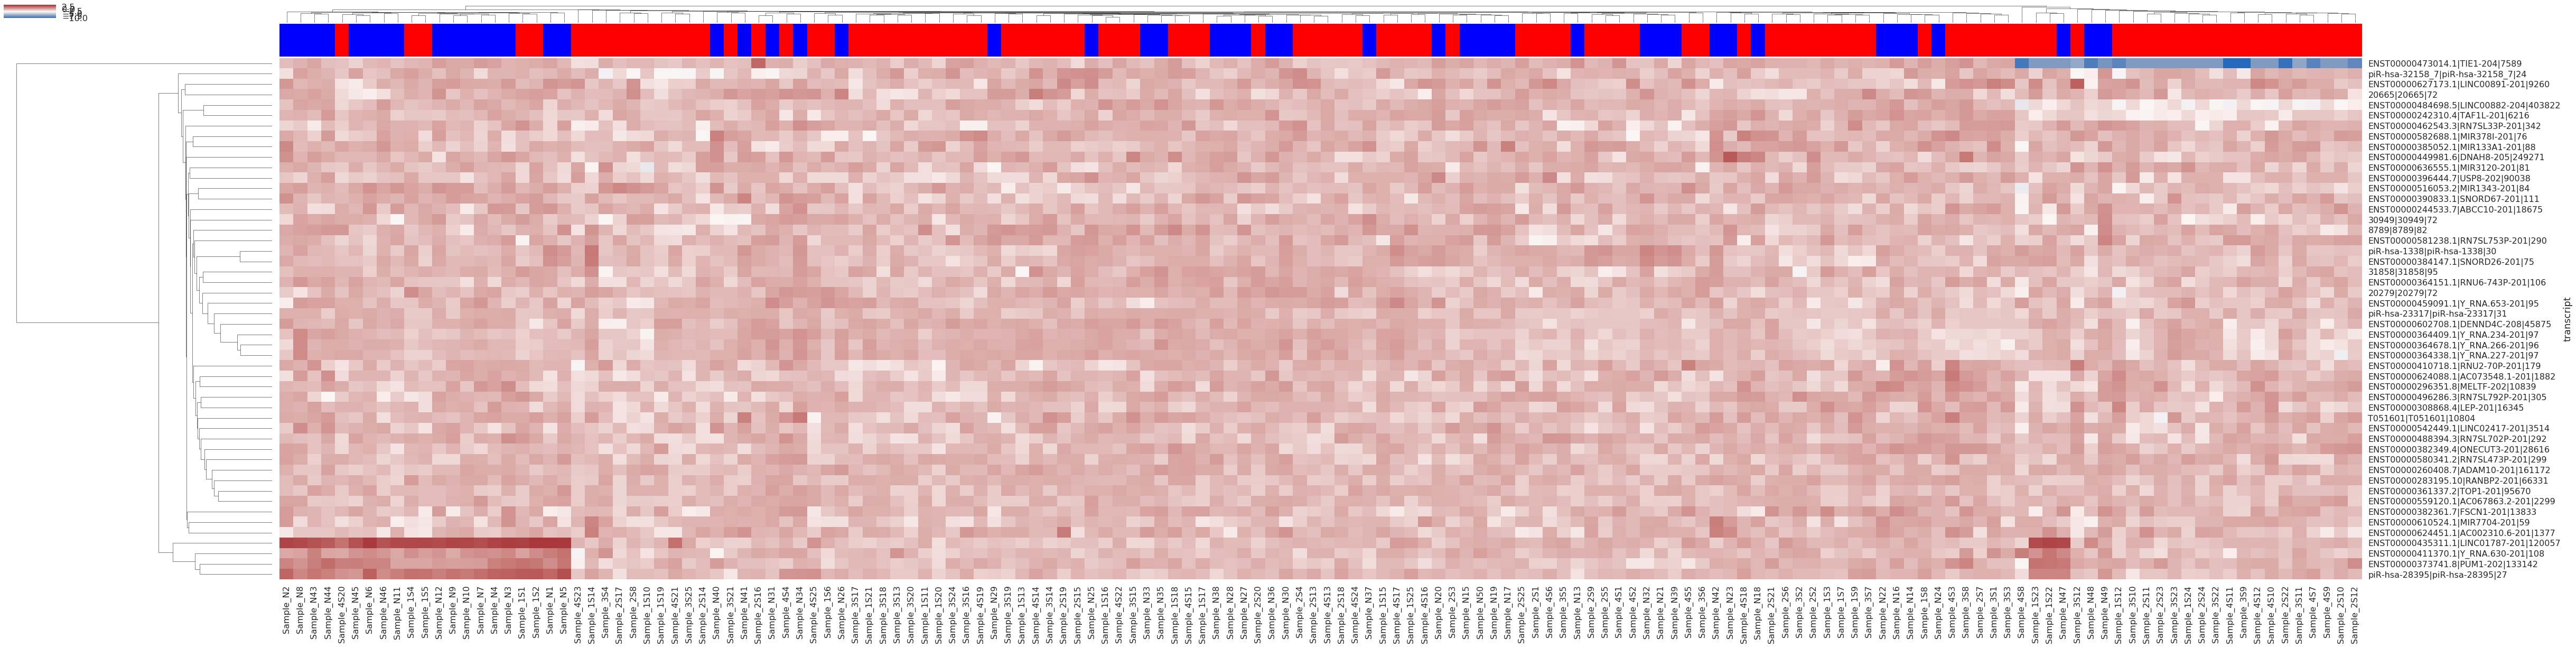

In [246]:
clustermap_crc('/home/chenxupeng/projects/training/data/GSE71008/','logistic_regression.50.ranking.stratified_shuffle_split','data/clustermap/'+
               '/home/chenxupeng/projects/training/data/GSE71008/'.split('/')[-2]+'/'+'Normal-CRC/'+'logistic_regression.50.ranking.stratified_shuffle_split'
               +'.png',savefigure=False,title=None)

In [39]:
root_path,sample_path

(['/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_removed/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccfull_ref_normalization/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_removed/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeak_ref_normalization/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_removed/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/hccpeakiter_ref_normalization/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_removed/',
  '/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_ref_normalization/'],
 ['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/'])

In [40]:
# root_path[0:6] sample_path[0:2]
# root_path[6:8] sample_path[2:3]

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
logistic_regression.4.robust.stratified_shuffle_split  fi

logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.6.robust.stratified_shuffle_split
random_forest.6.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-stage_A/random_forest.6.robust.stratified_shuffle_split.png
random_forest.8.robust.stratified_shuffle_split
random_forest.8.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-stage_A/random_forest.8.robust.stratified_shuffle_split.png
random_forest.10.robust.stratified_shuffle_split
random_forest.10.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_removed/Normal-stage_A/random_forest.10.robust.stratified_shuffle_split.png
logistic_regression.8.robust.stratified_shuffle_split
logistic_regression.8.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_remo

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
logistic_regressi

logistic_regression.1.robust.stratified_shuffle_split
logistic_regression.1.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-stage_A/logistic_regression.1.robust.stratified_shuffle_split.png
logistic_regression.1.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
random_forest.4.robust.stratified_shuffle_split
random_forest.4.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-stage_A/random_forest.4.robust.stratified_shuffle_split.png
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/hccfull_ref_normalization/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.6.robust.stratified_shuffle_split

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
logistic_regression.4.robust.stratified_shuffle_split  fi

logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.6.robust.stratified_shuffle_split
random_forest.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-stage_A/random_forest.6.robust.stratified_shuffle_split.png
random_forest.8.robust.stratified_shuffle_split
random_forest.8.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-stage_A/random_forest.8.robust.stratified_shuffle_split.png
random_forest.10.robust.stratified_shuffle_split
random_forest.10.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_removed/Normal-stage_A/random_forest.10.robust.stratified_shuffle_split.png
logistic_regression.8.robust.stratified_shuffle_split
logistic_regression.8.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_remo

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
logistic_regressi

logistic_regression.1.robust.stratified_shuffle_split
logistic_regression.1.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-stage_A/logistic_regression.1.robust.stratified_shuffle_split.png
logistic_regression.1.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
random_forest.4.robust.stratified_shuffle_split
random_forest.4.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-stage_A/random_forest.4.robust.stratified_shuffle_split.png
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/hccpeak_ref_normalization/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.6.robust.stratified_shuffle_split

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
logistic_regression.4.robust.stratified_s

logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.6.robust.stratified_shuffle_split
random_forest.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-stage_A/random_forest.6.robust.stratified_shuffle_split.png
random_forest.8.robust.stratified_shuffle_split
random_forest.8.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-stage_A/random_forest.8.robust.stratified_shuffle_split.png
random_forest.10.robust.stratified_shuffle_split
random_forest.10.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_removed/Normal-stage_A/random_forest.10.robust.stratified_shuffle_split.png
logistic_regression.8.robust.stratified_shuffle_split
logistic_regression.8.robust.stratified_shuffle_split  file found
data/cluster

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-HCC/logistic_regression.6.robust.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-HCC/logistic_regression.9.robust.stratified_shuffle_split.png
true
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-HCC/random_forest.9.robust.stratified_shuffle_split.png
true
logistic_regression.4.robust.stratified_shuffle_split
l

random_forest.50.robust.stratified_shuffle_split
random_forest.50.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-stage_A/random_forest.50.robust.stratified_shuffle_split.png
logistic_regression.1.robust.stratified_shuffle_split
logistic_regression.1.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-stage_A/logistic_regression.1.robust.stratified_shuffle_split.png
logistic_regression.1.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
random_forest.4.robust.stratified_shuffle_split
random_forest.4.robust.stratified_shuffle_split  file found
data/clustermap/hccpeakiter_ref_normalization/Normal-stage_A/random_forest.4.robust.stratified_shuffle_split.png
logistic_regression.40.robust.stratified_shuffle_spli

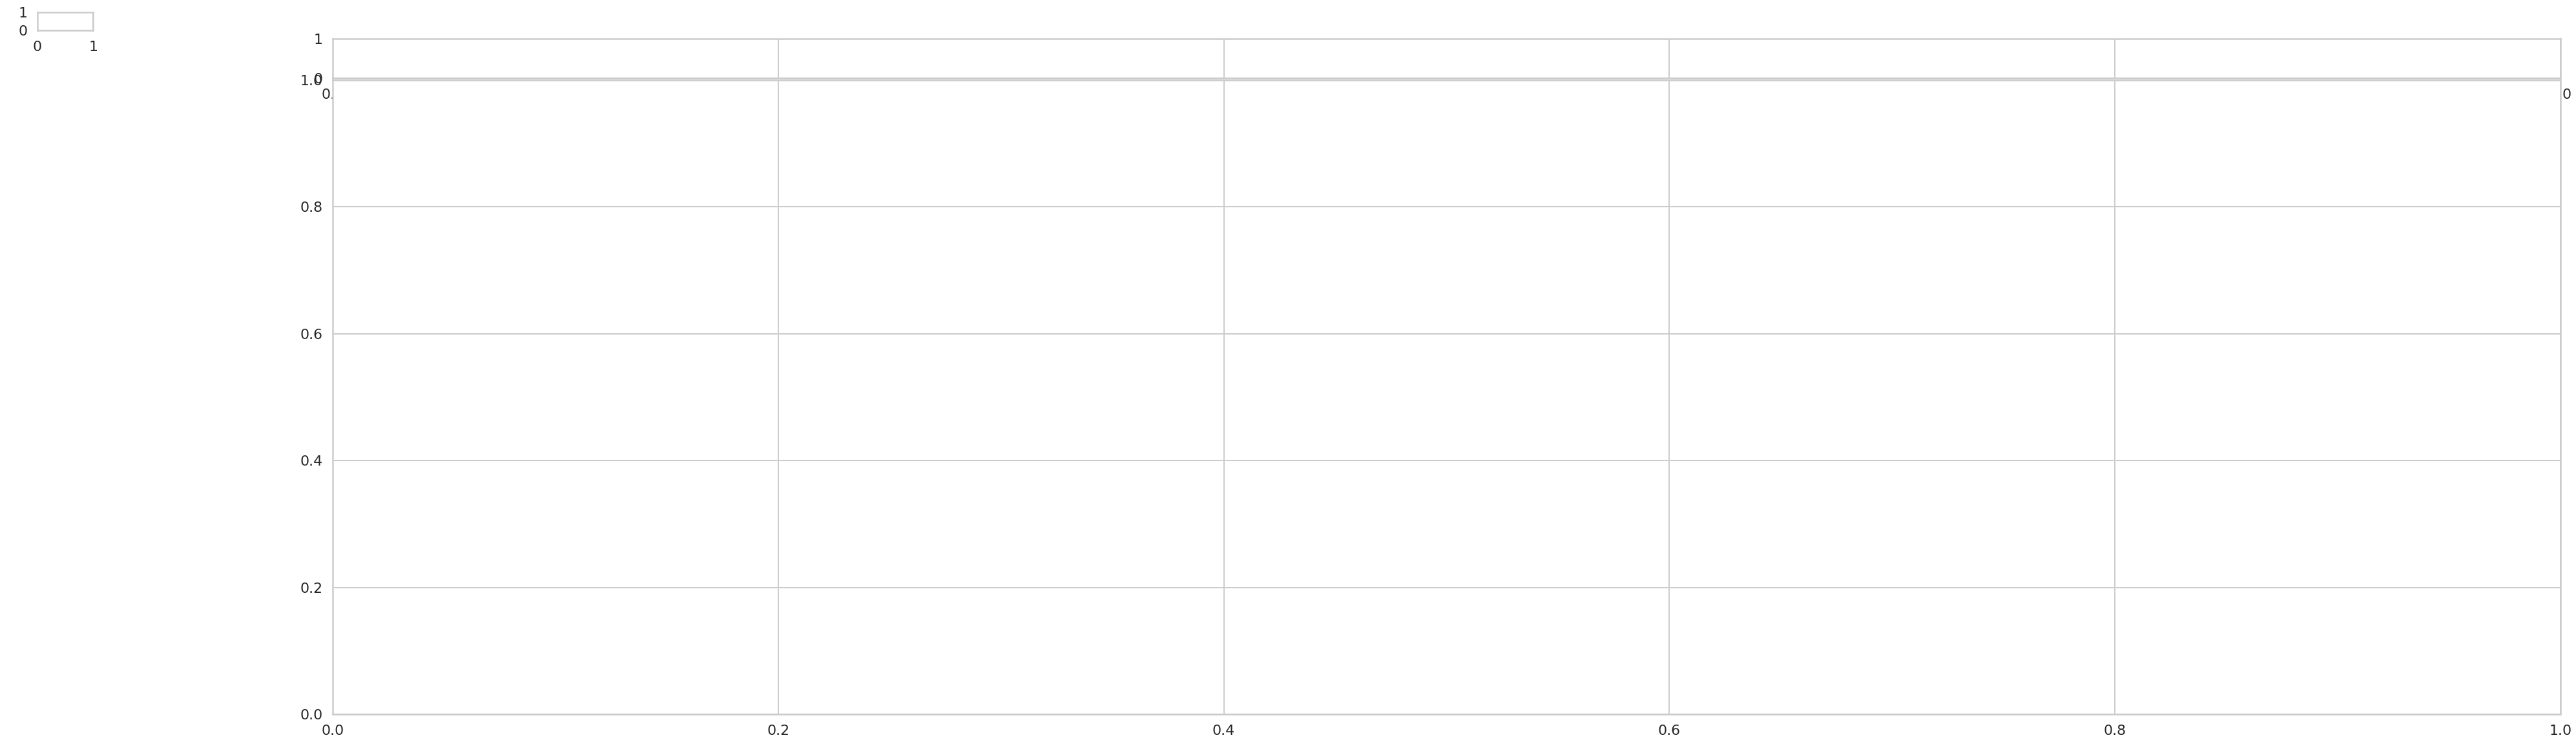

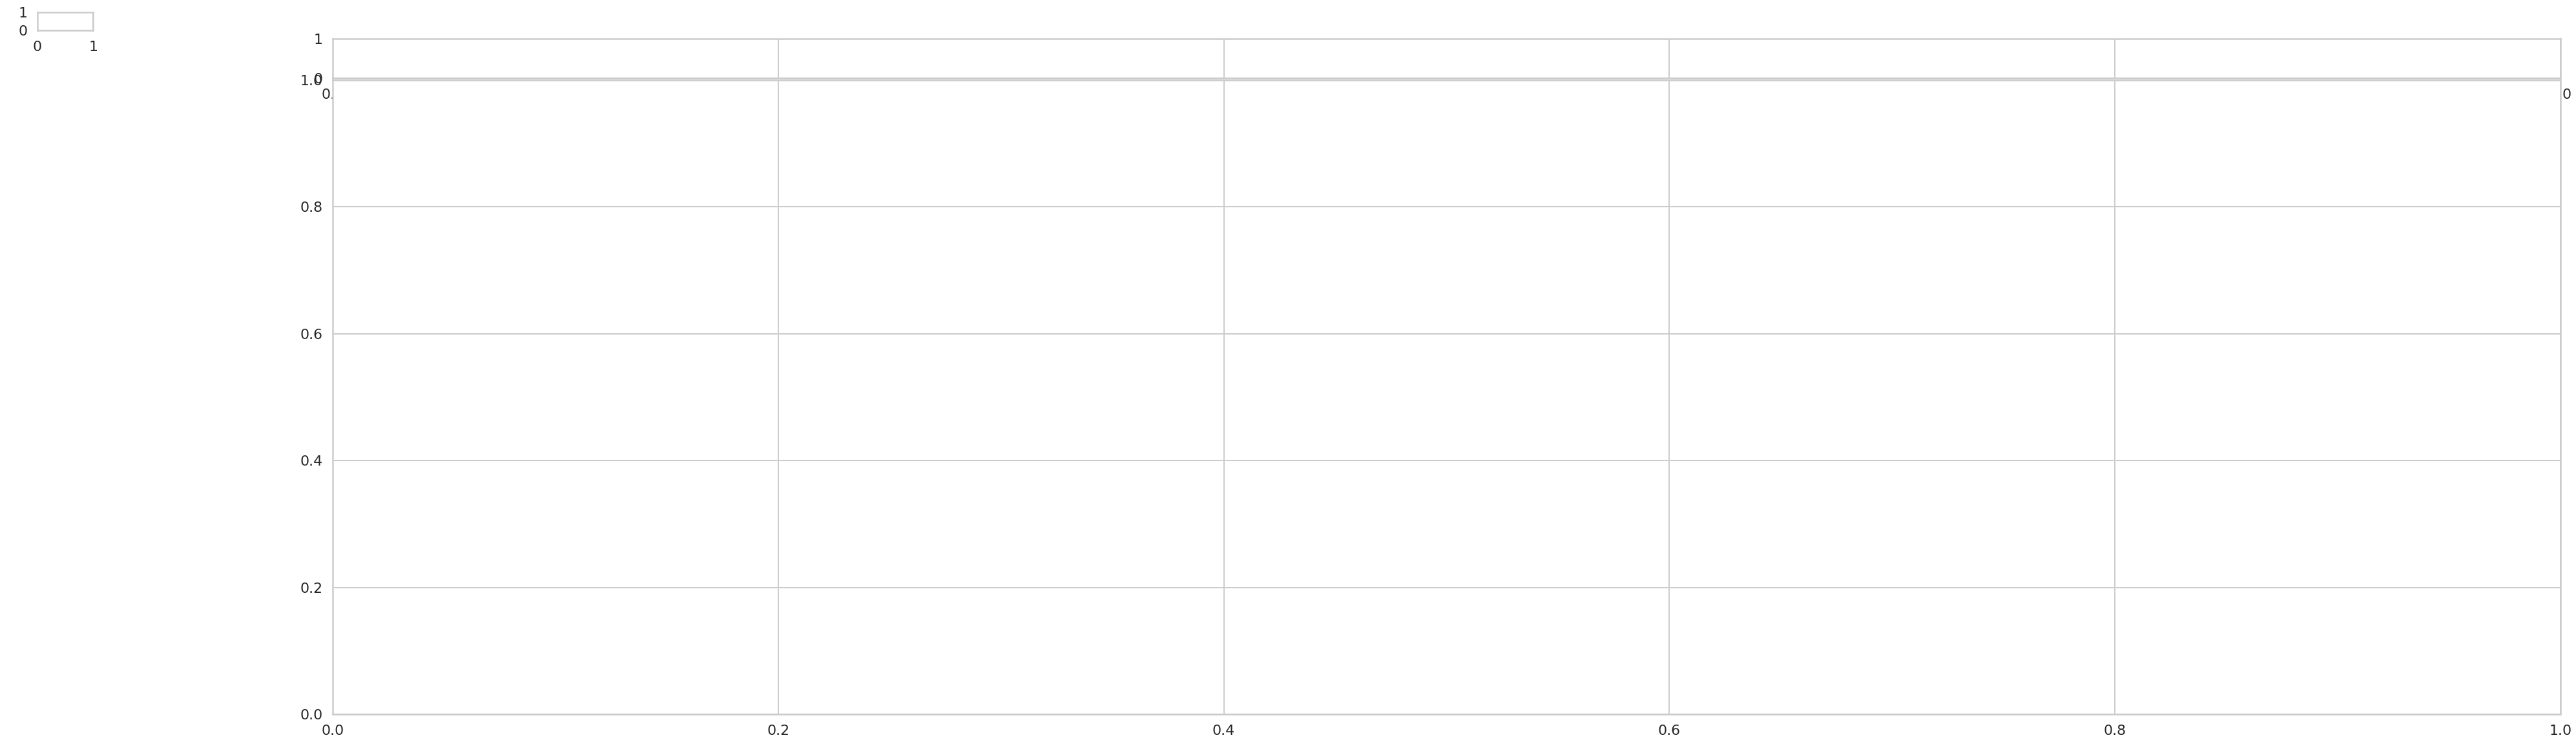

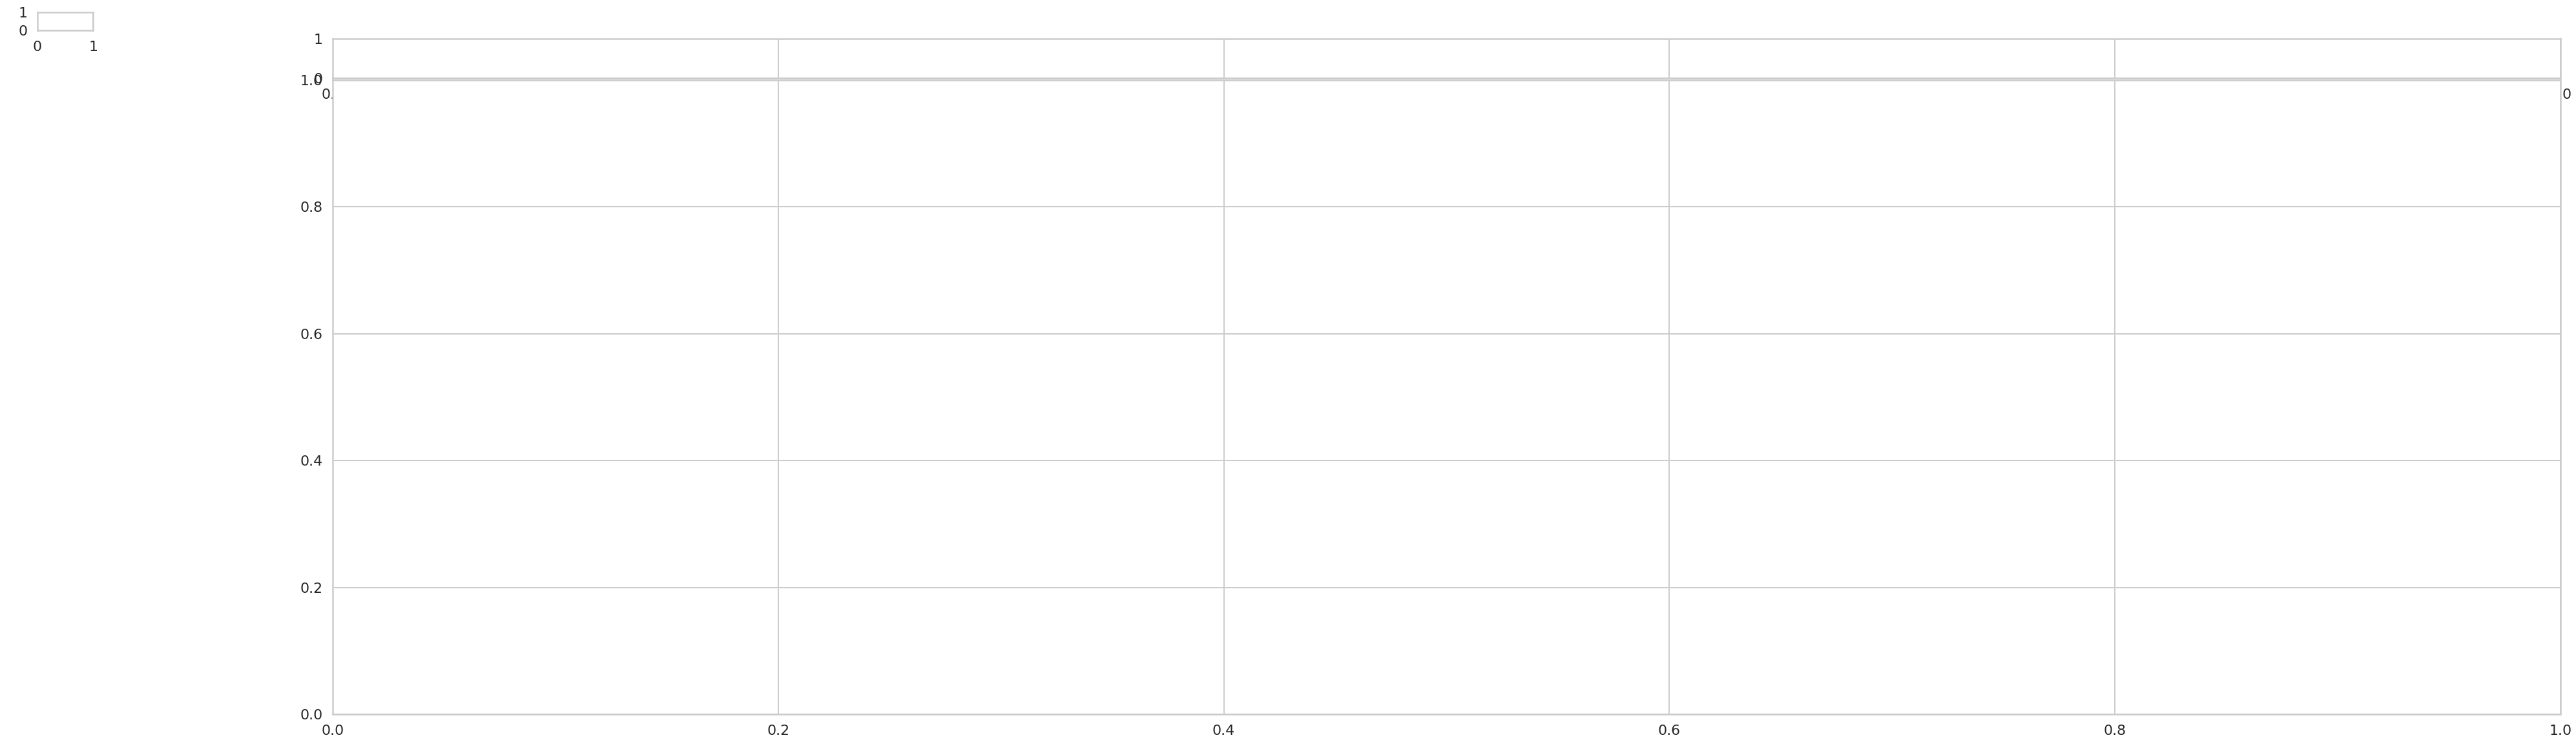

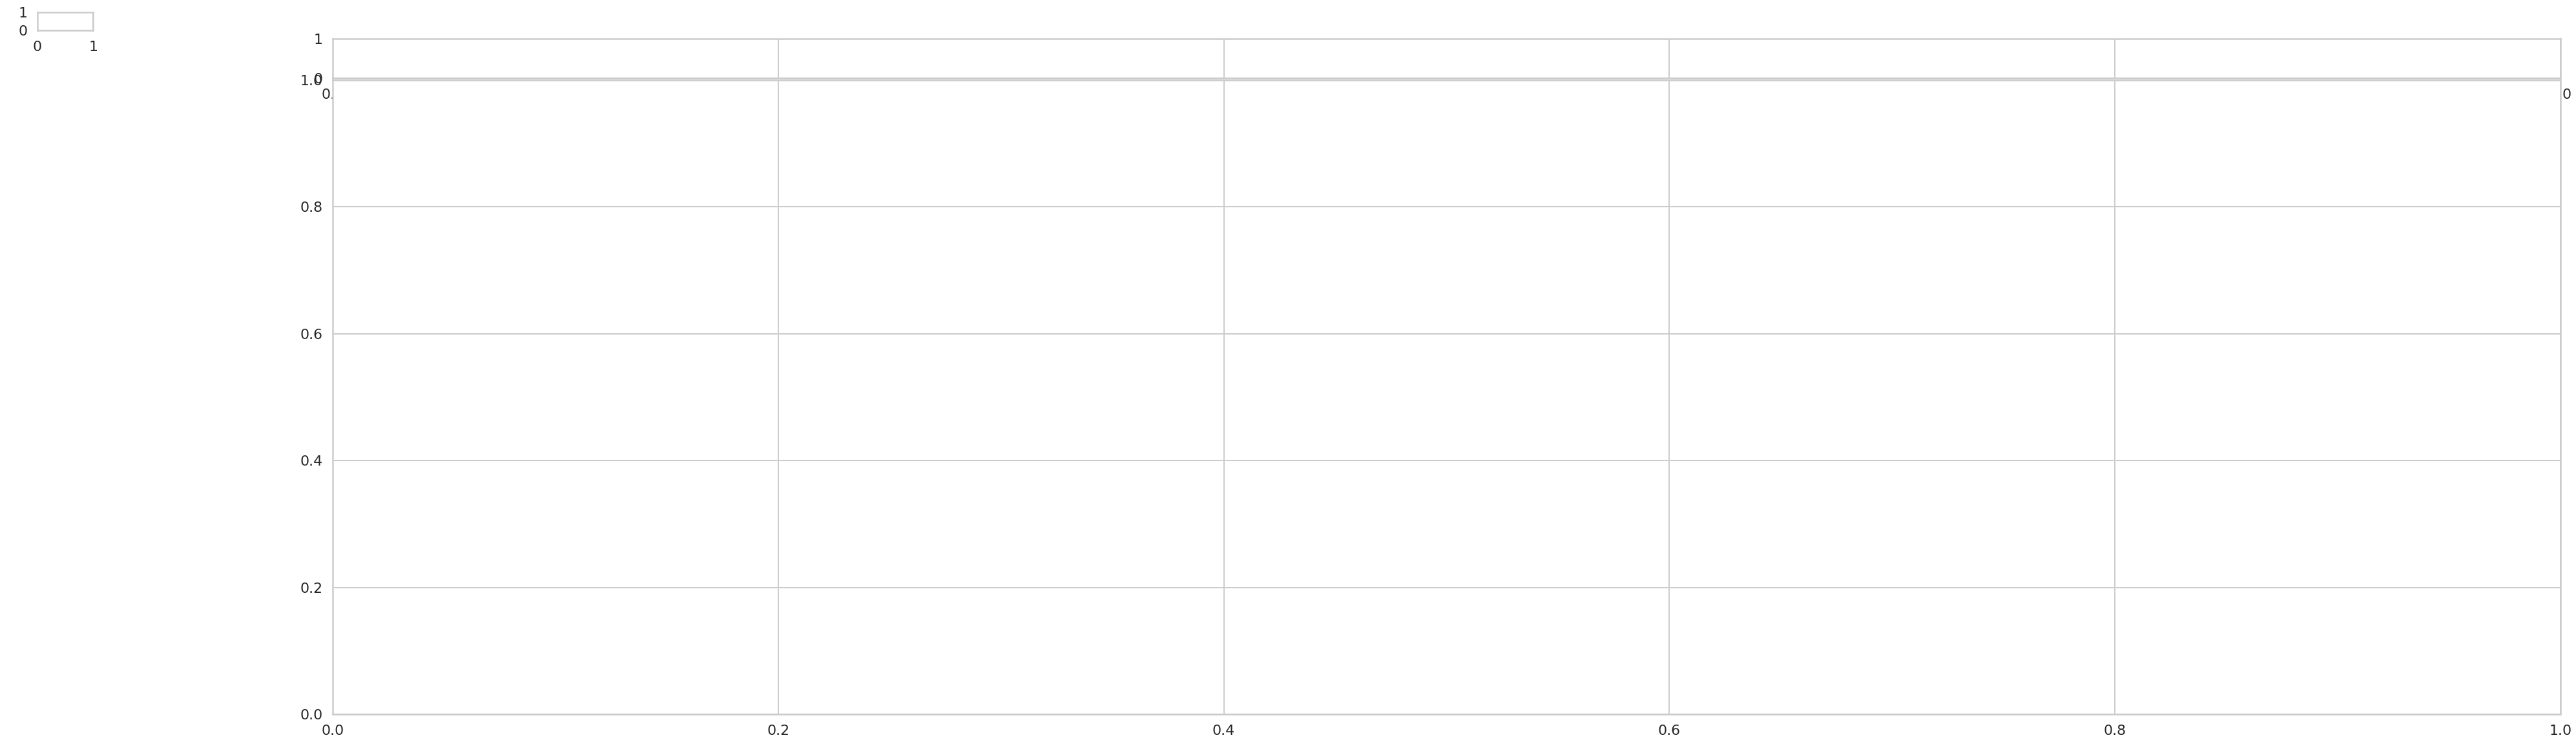

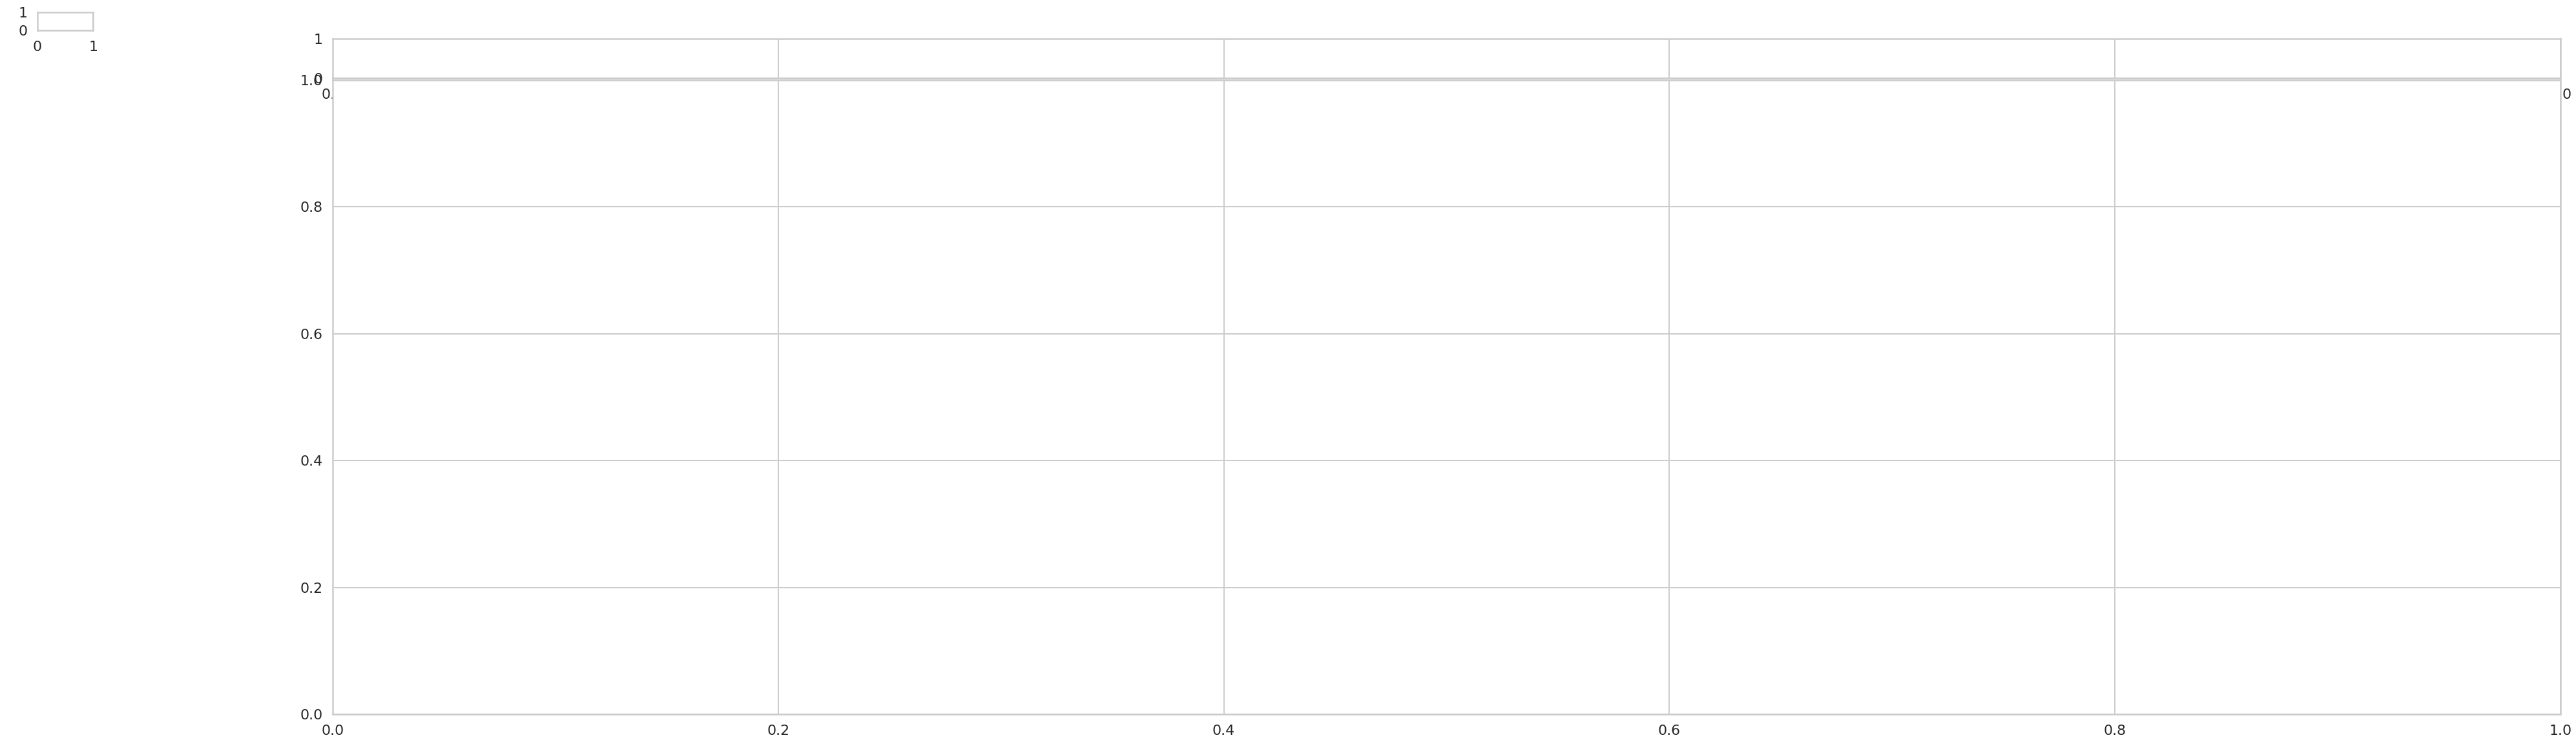

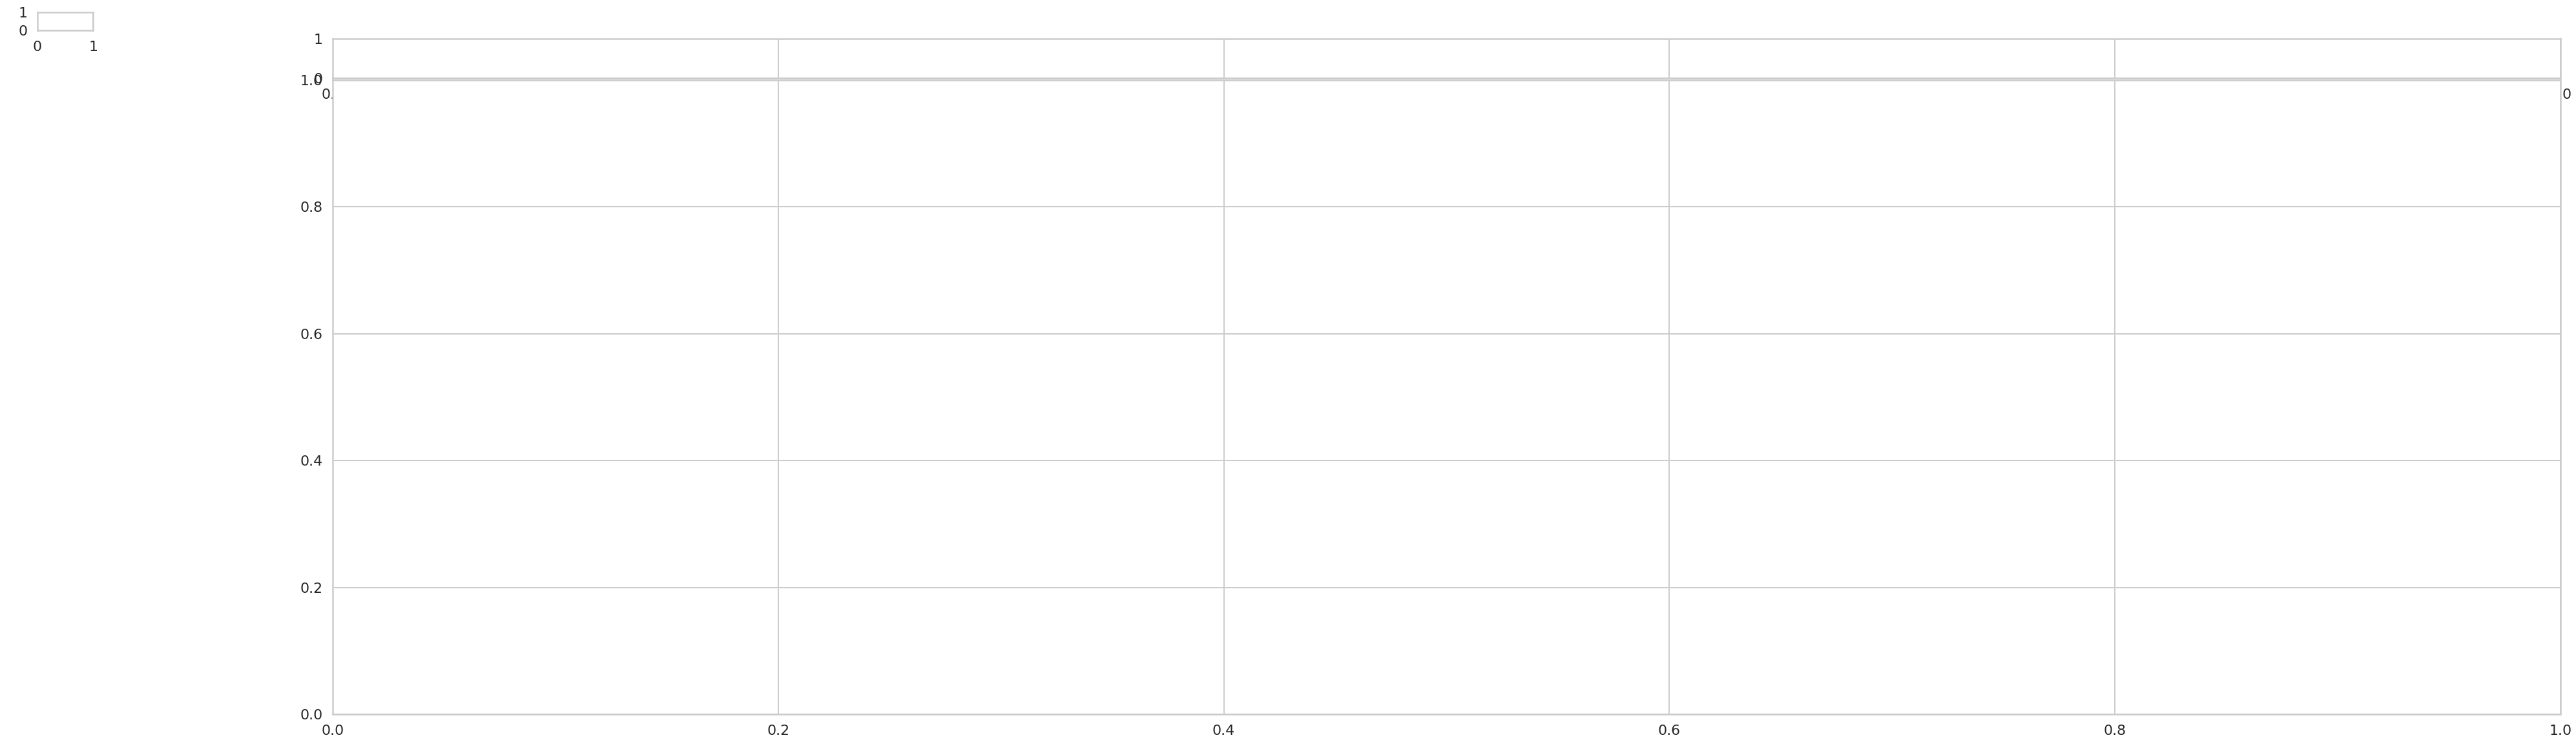

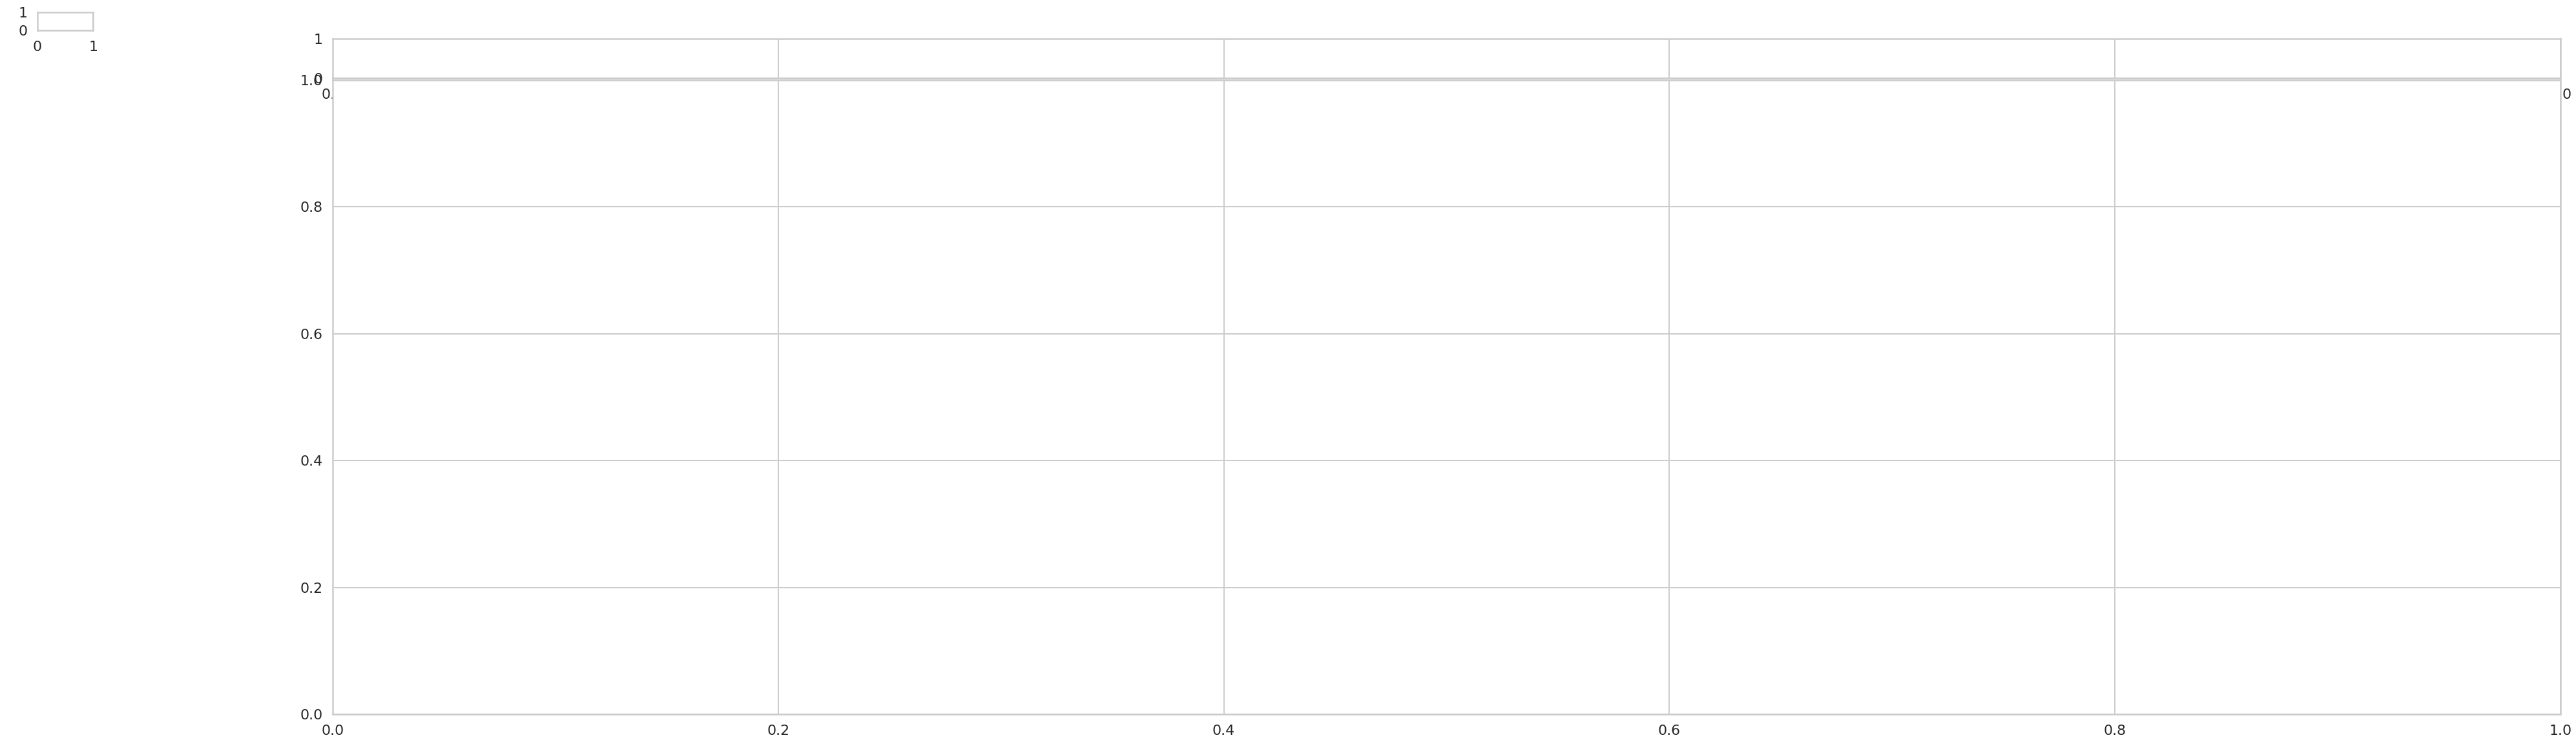

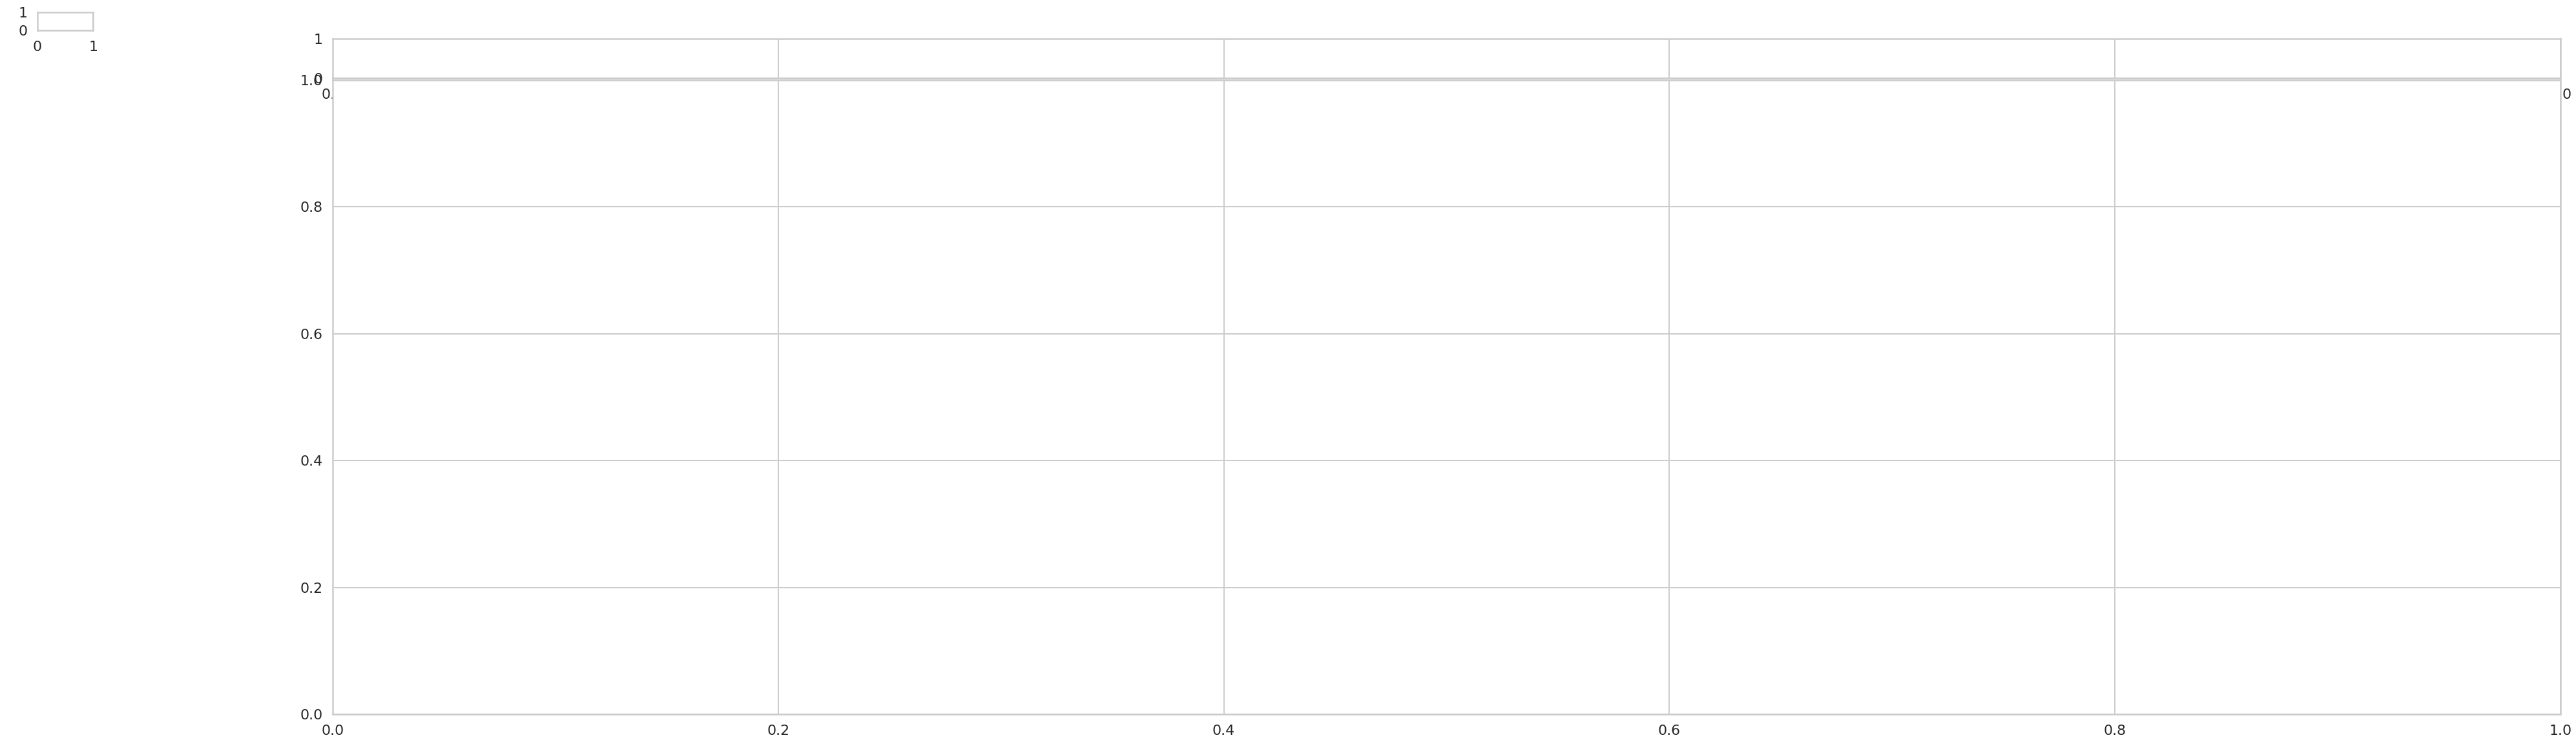

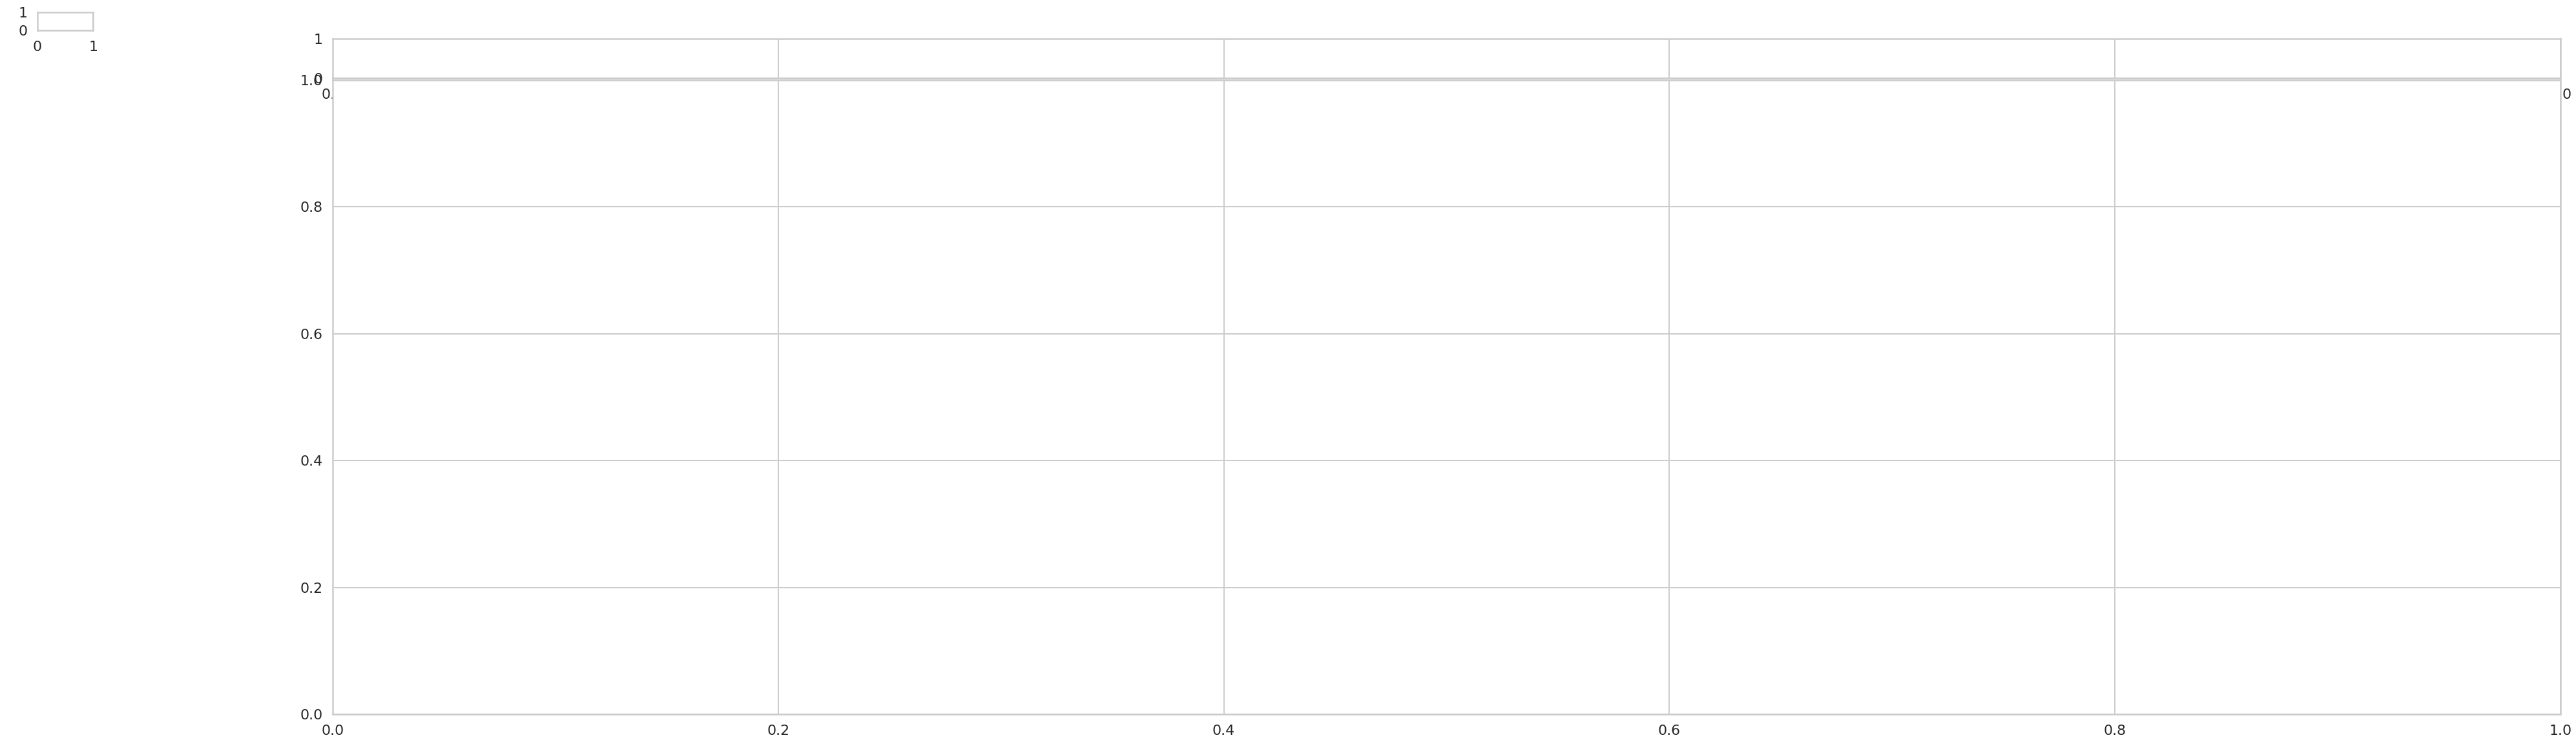

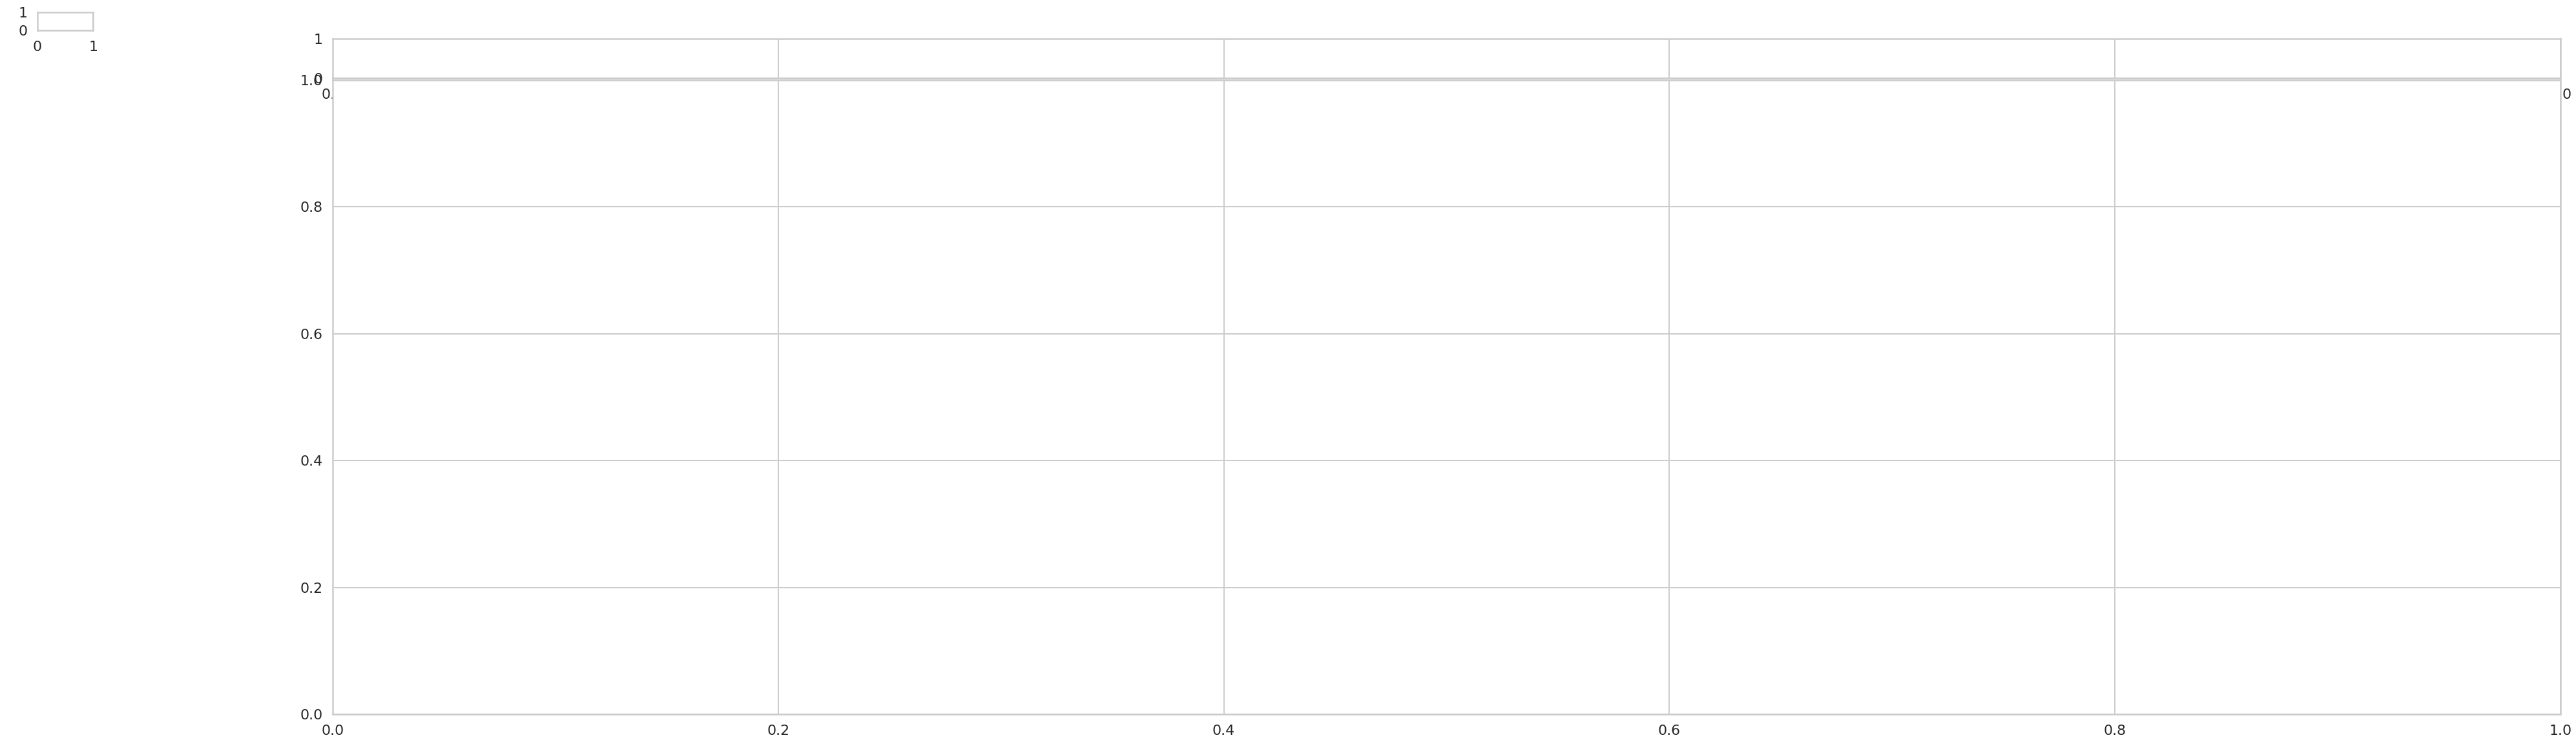

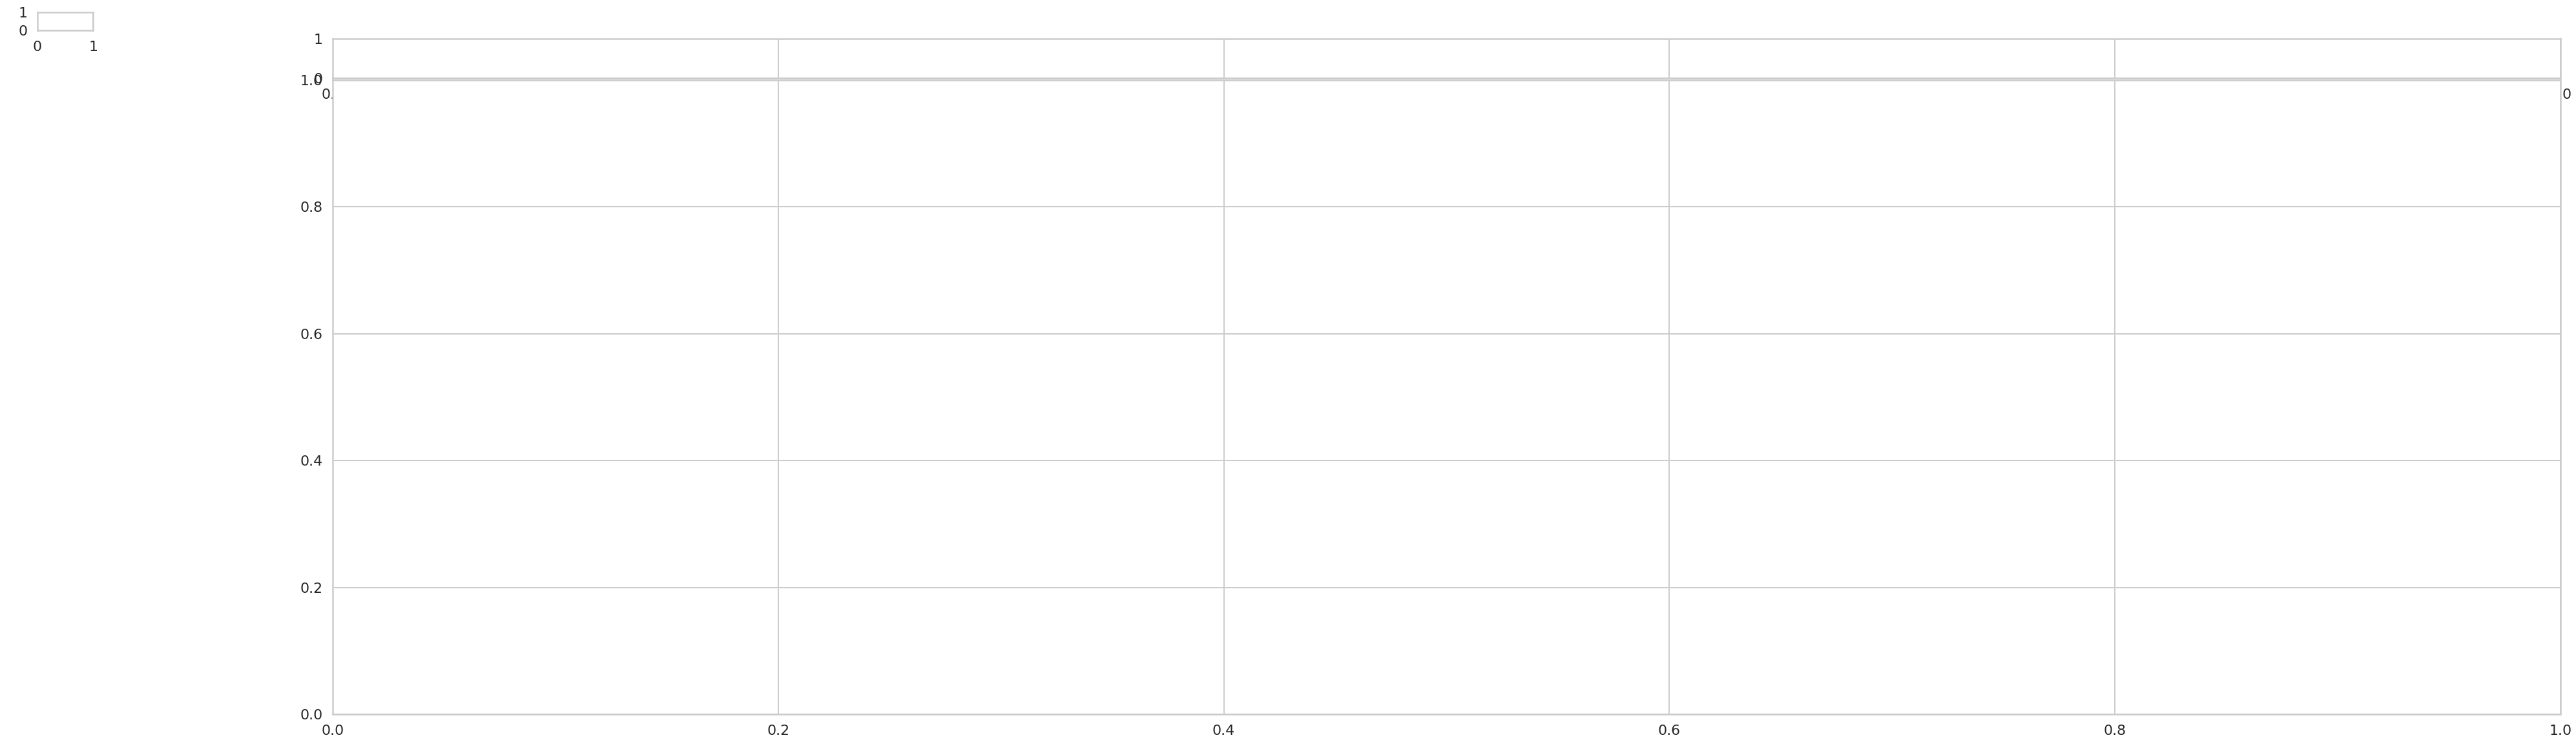

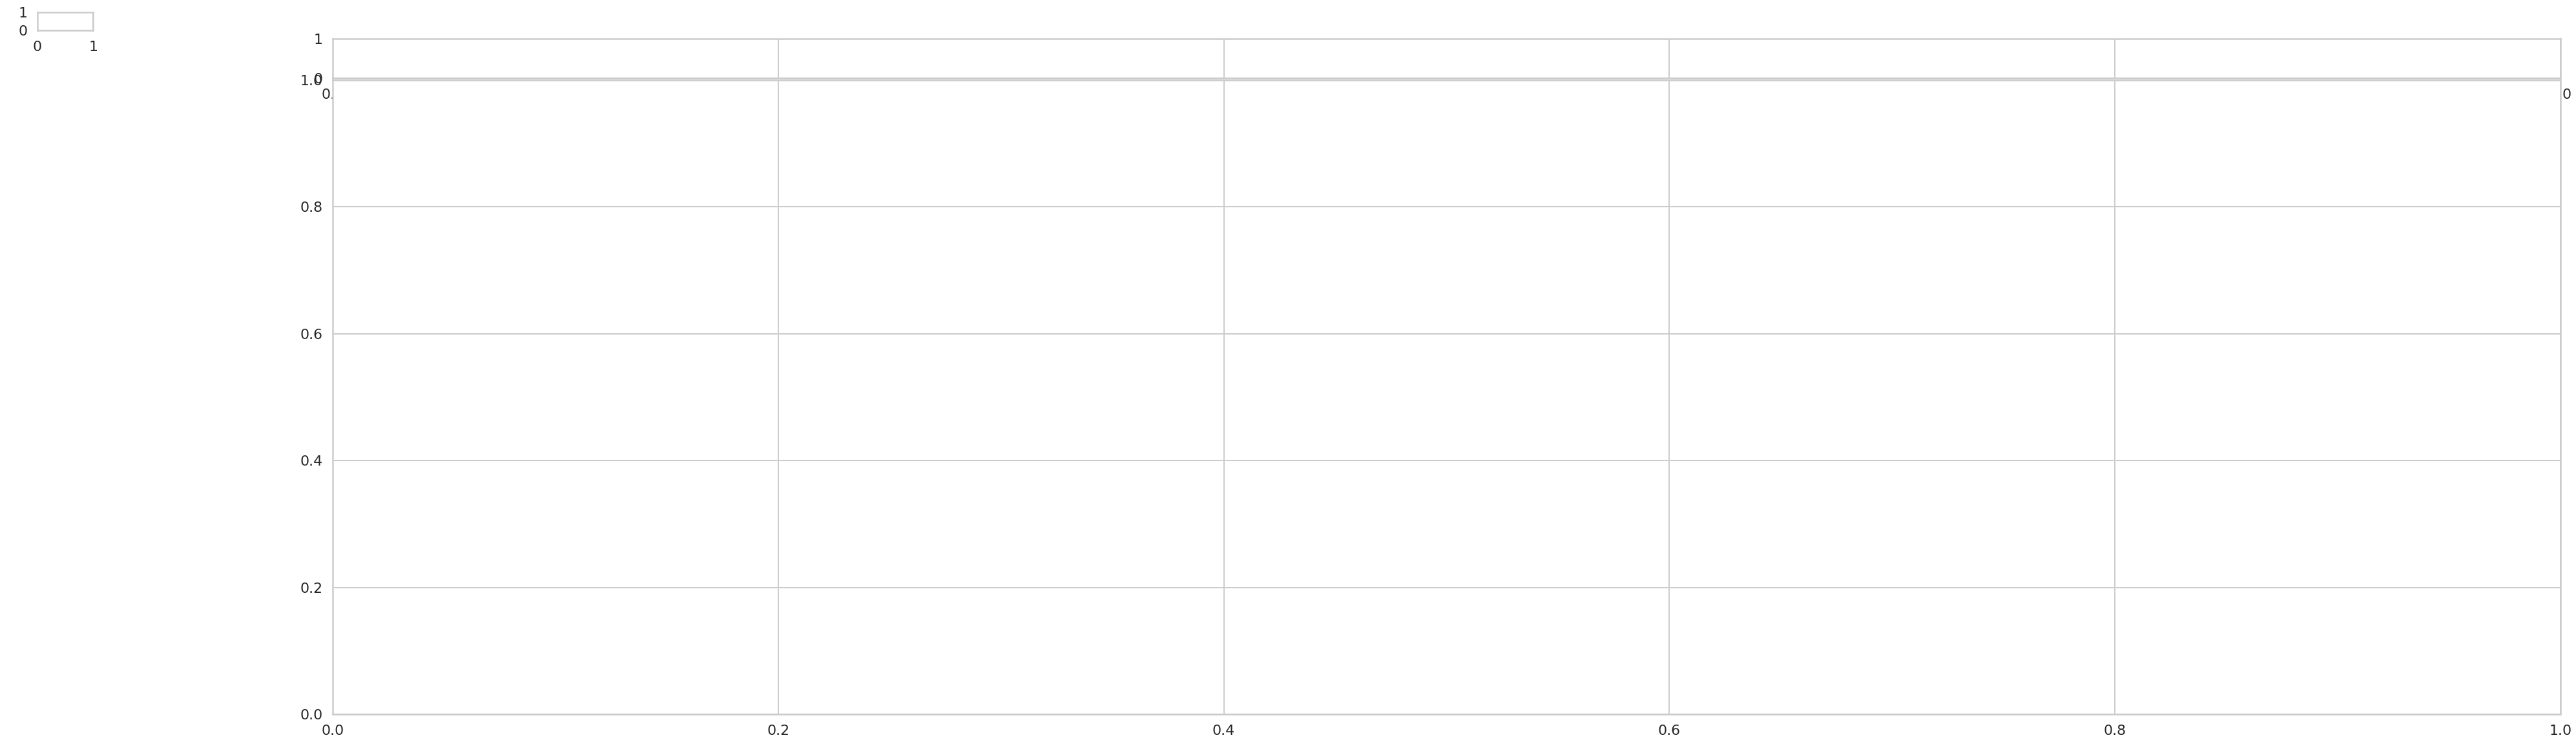

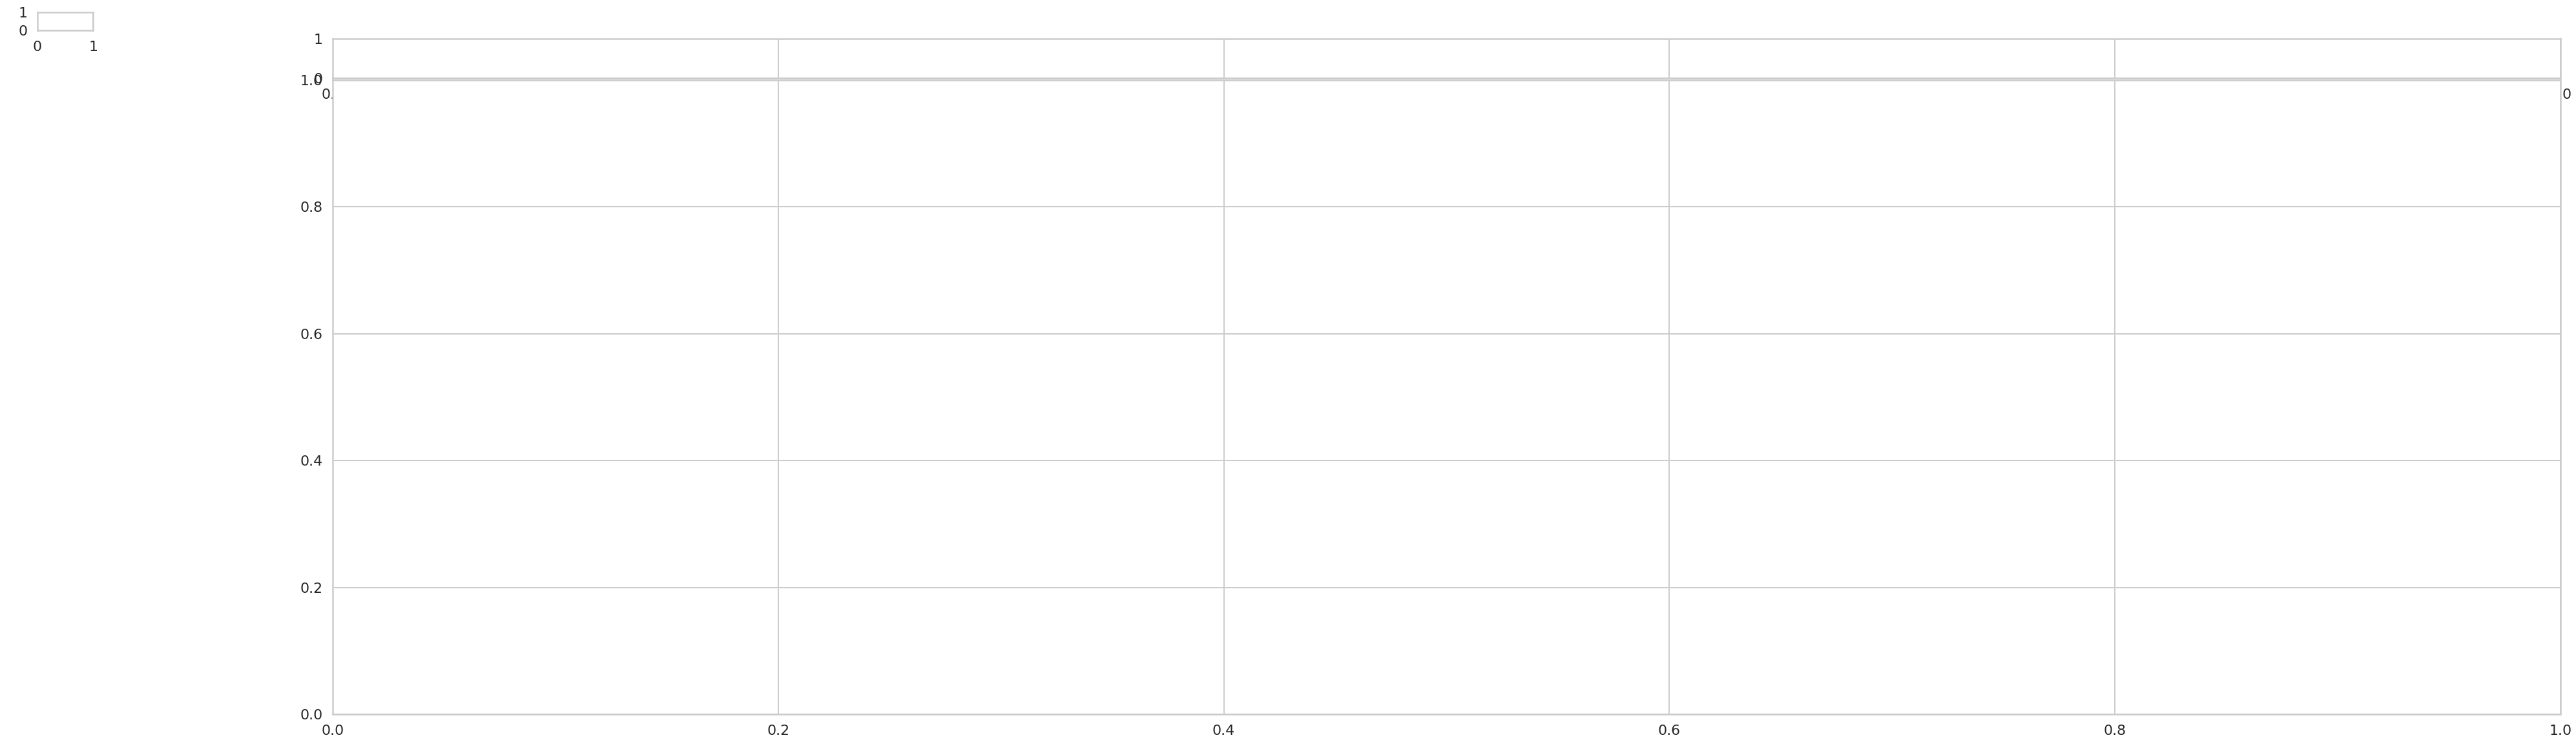

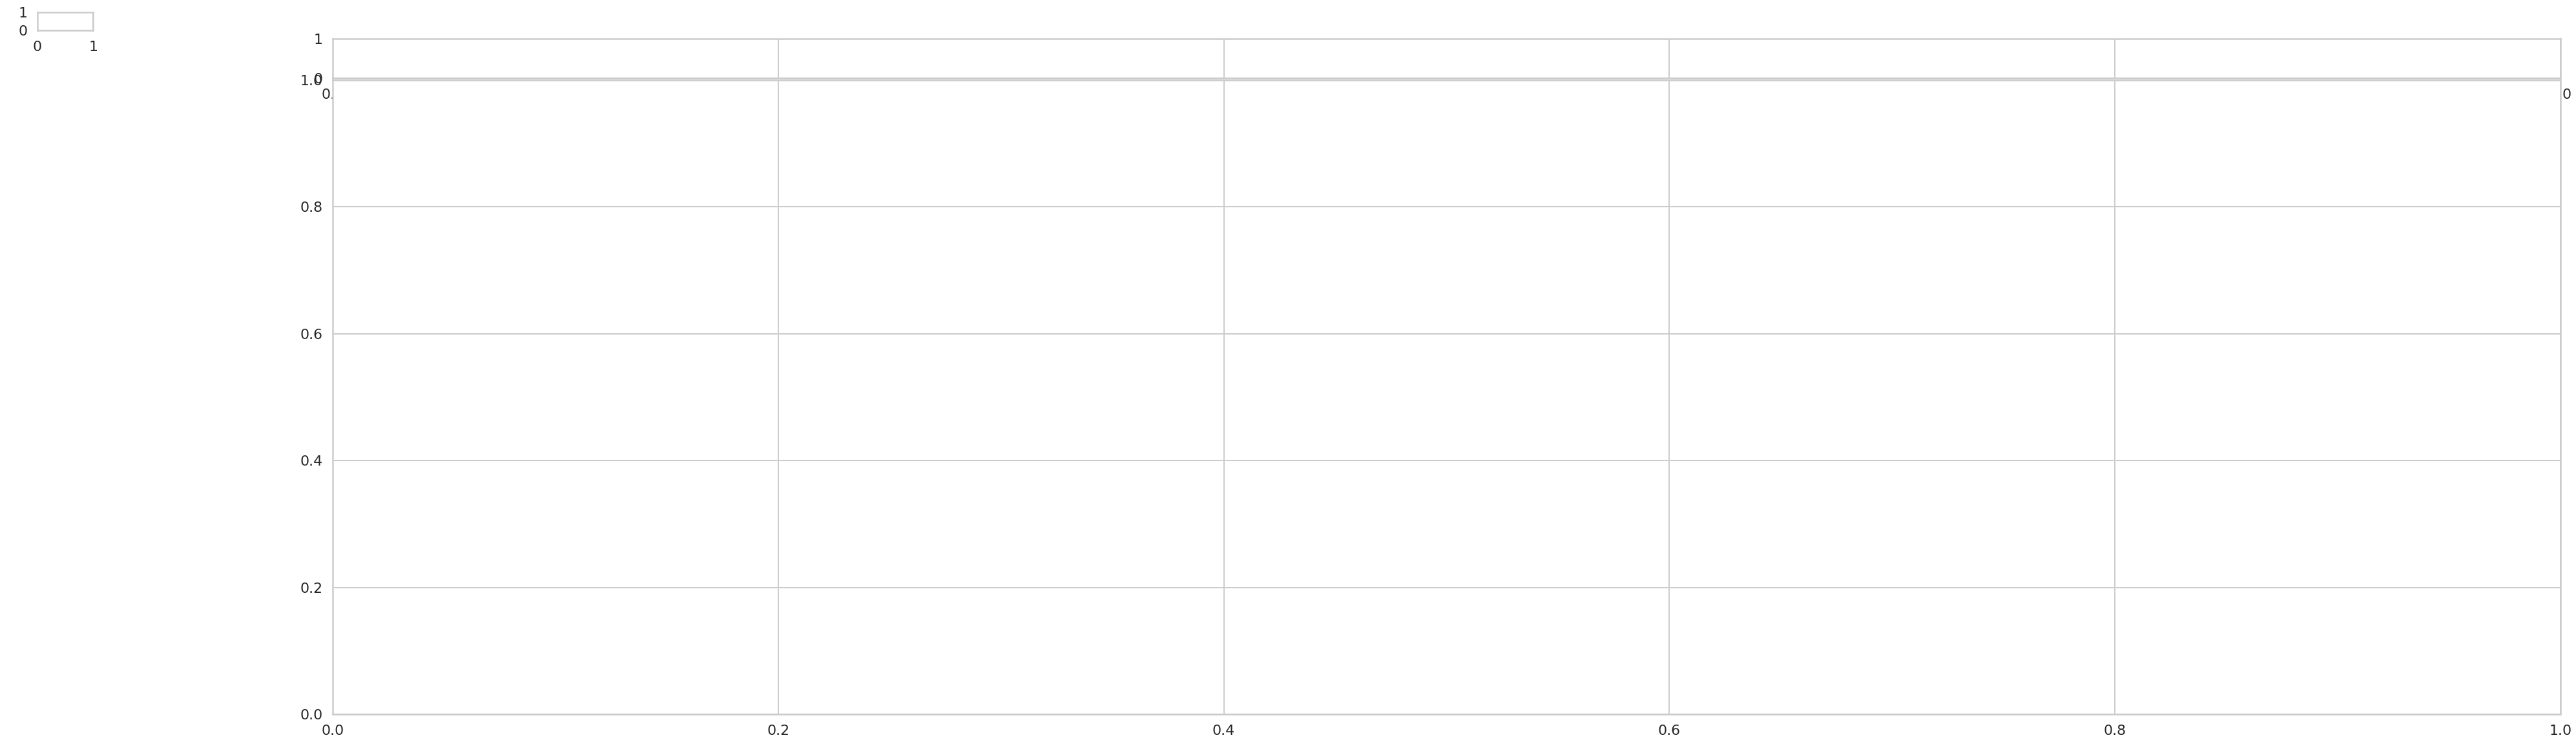

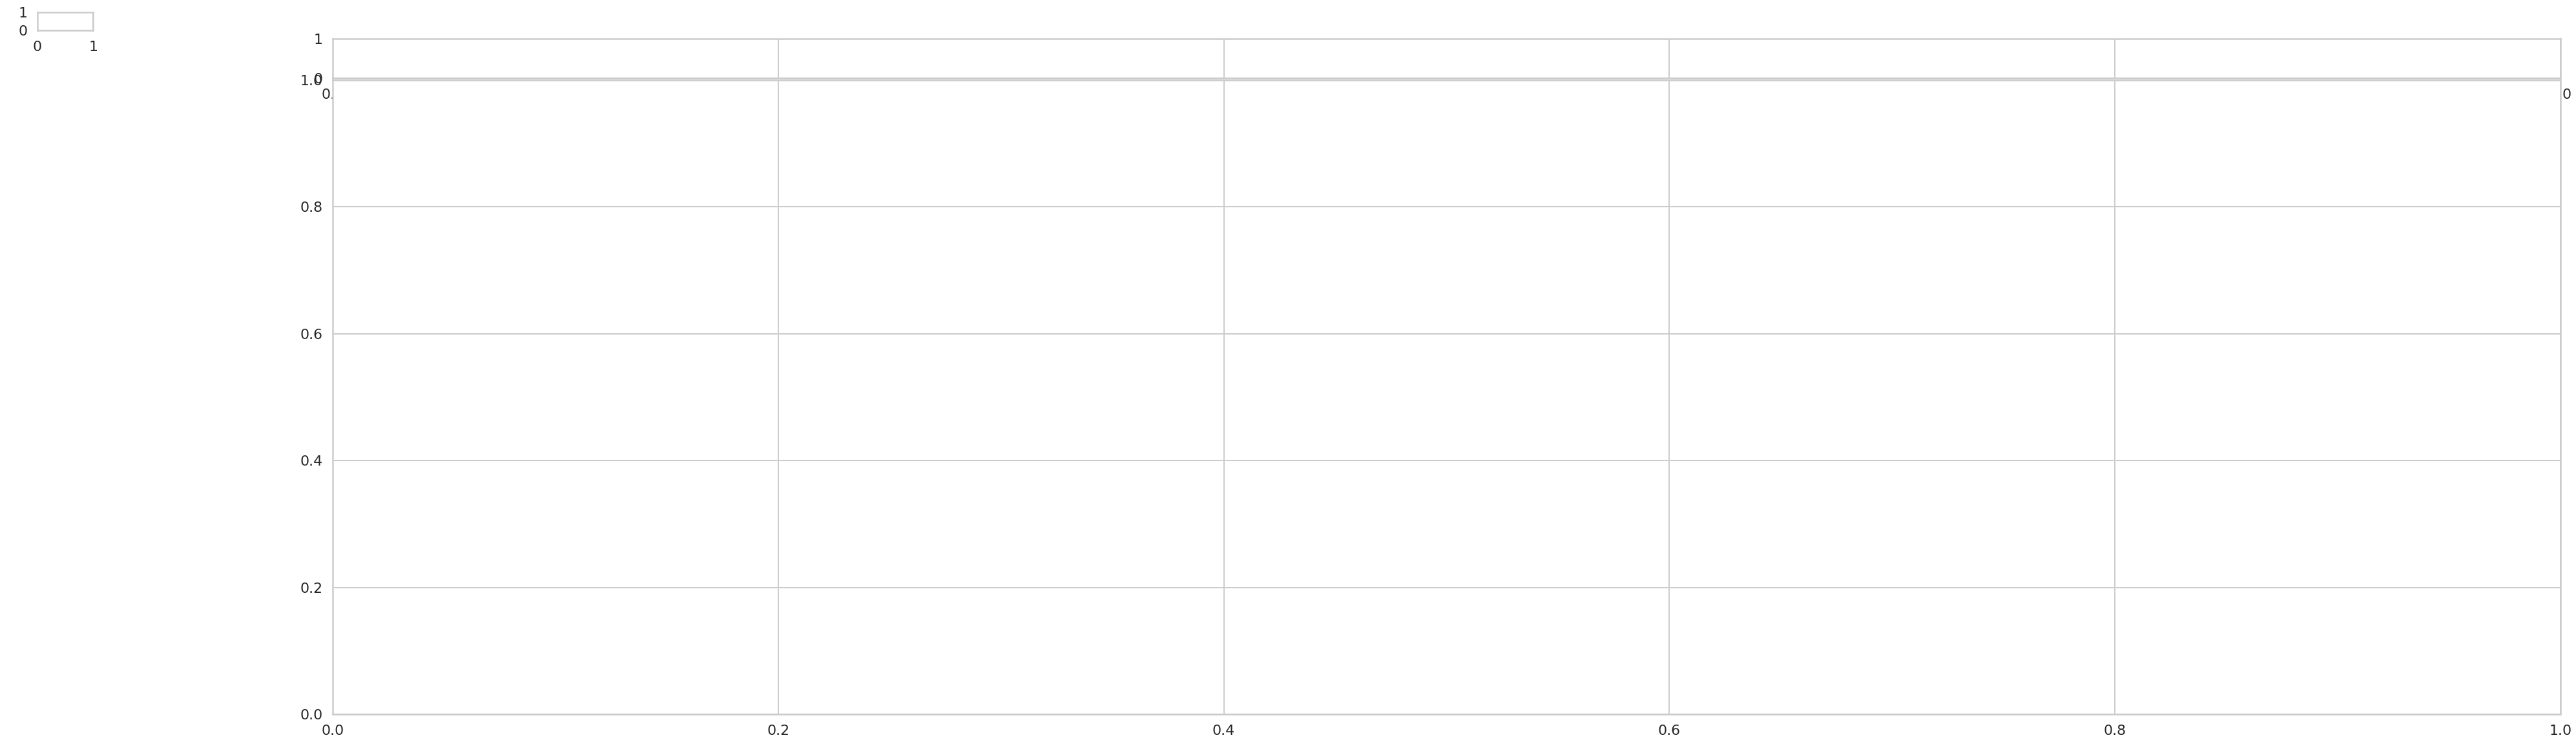

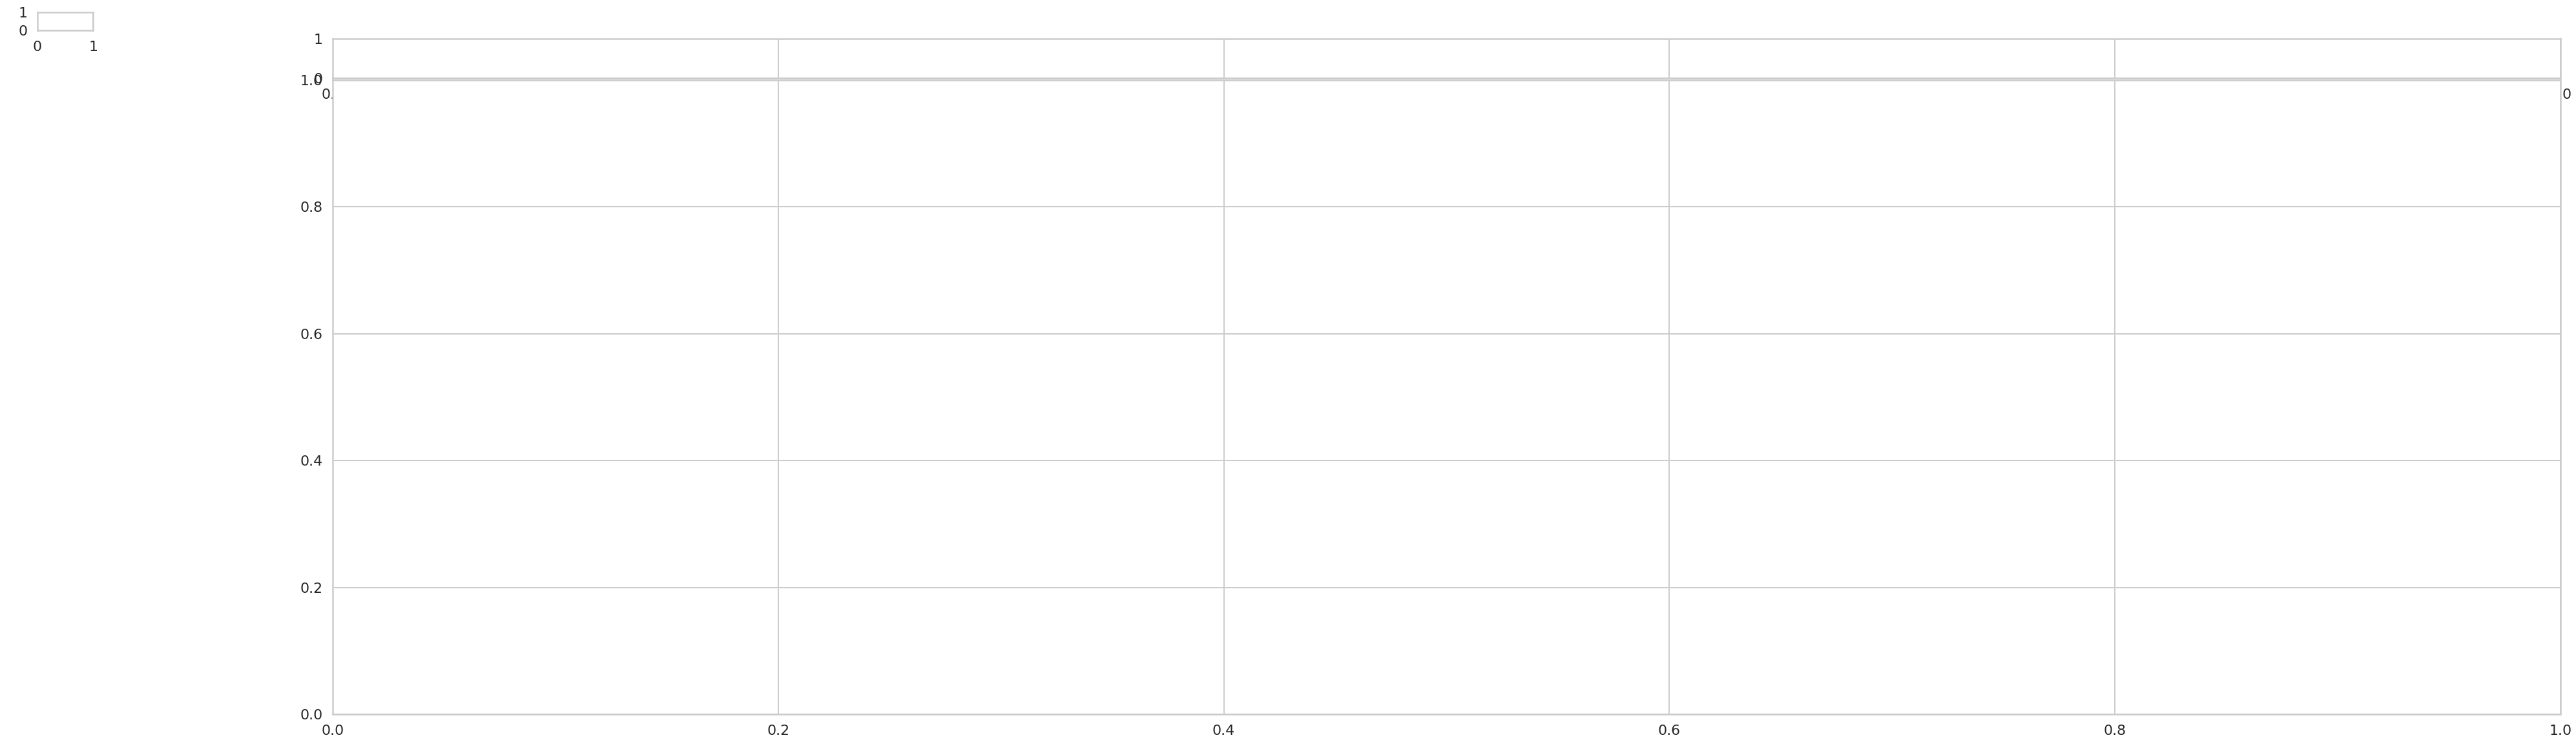

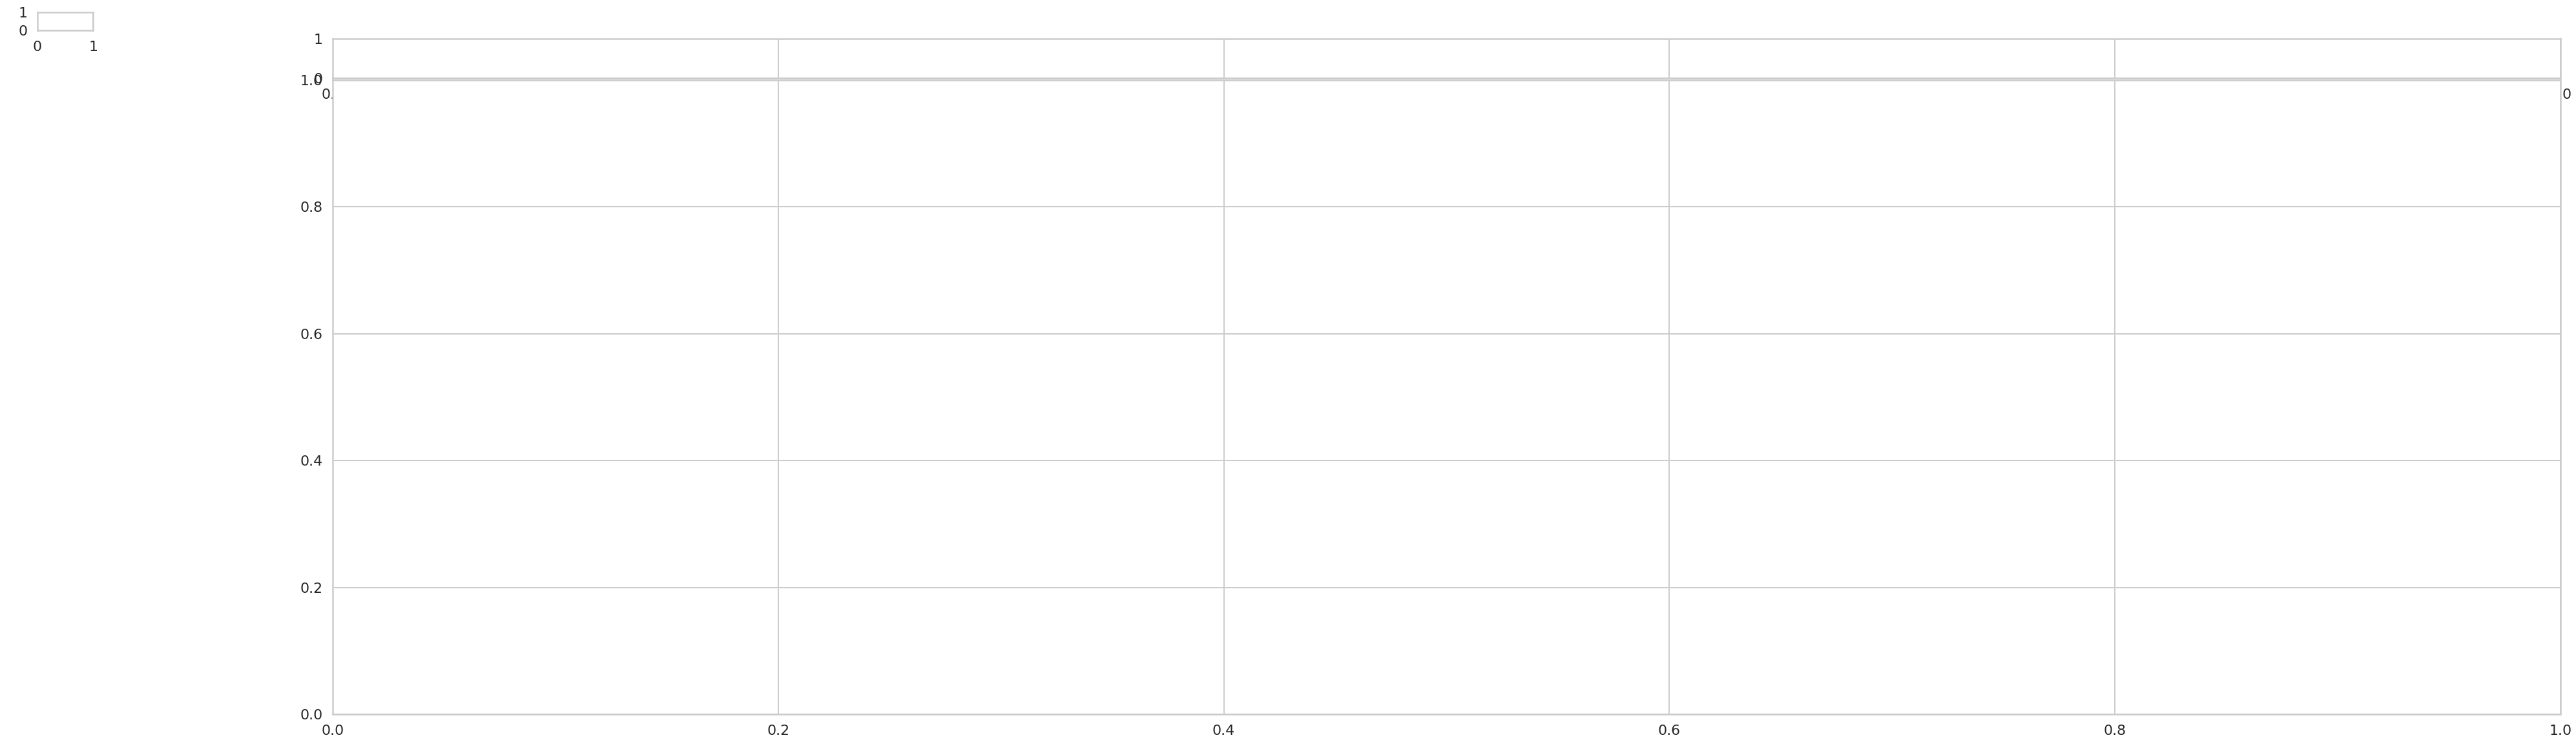

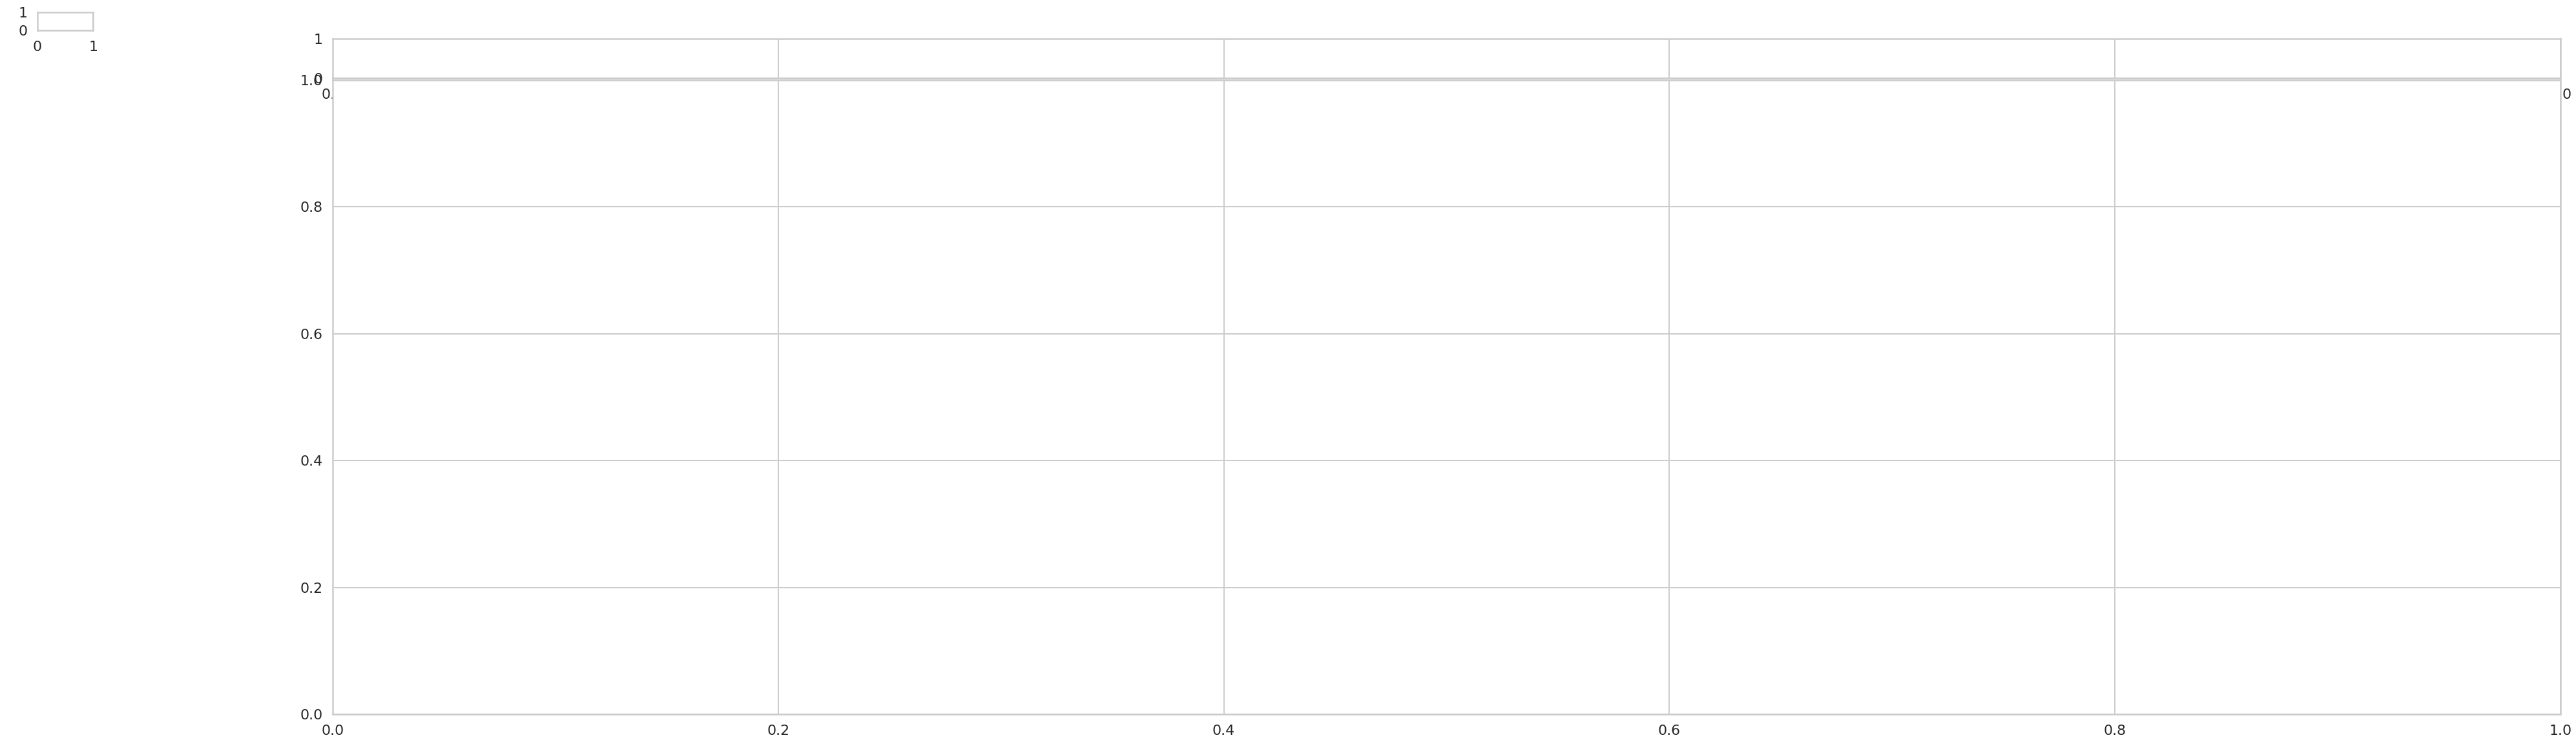

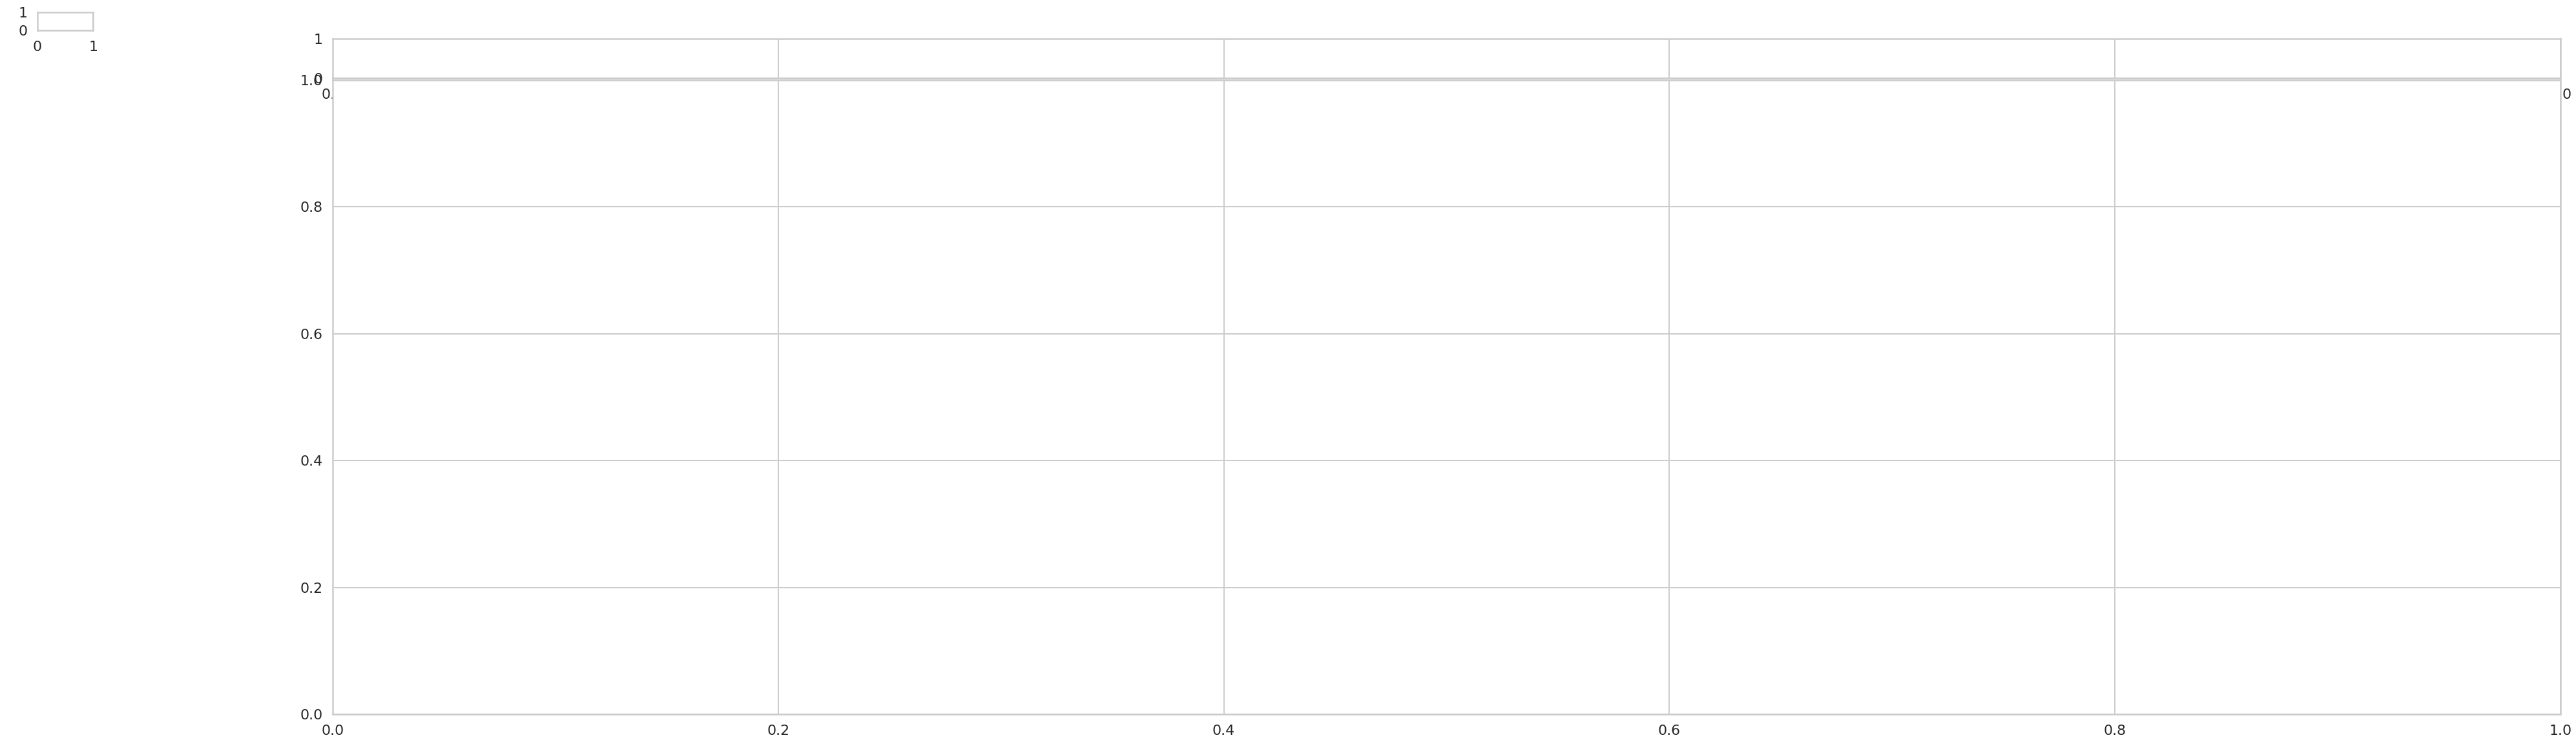

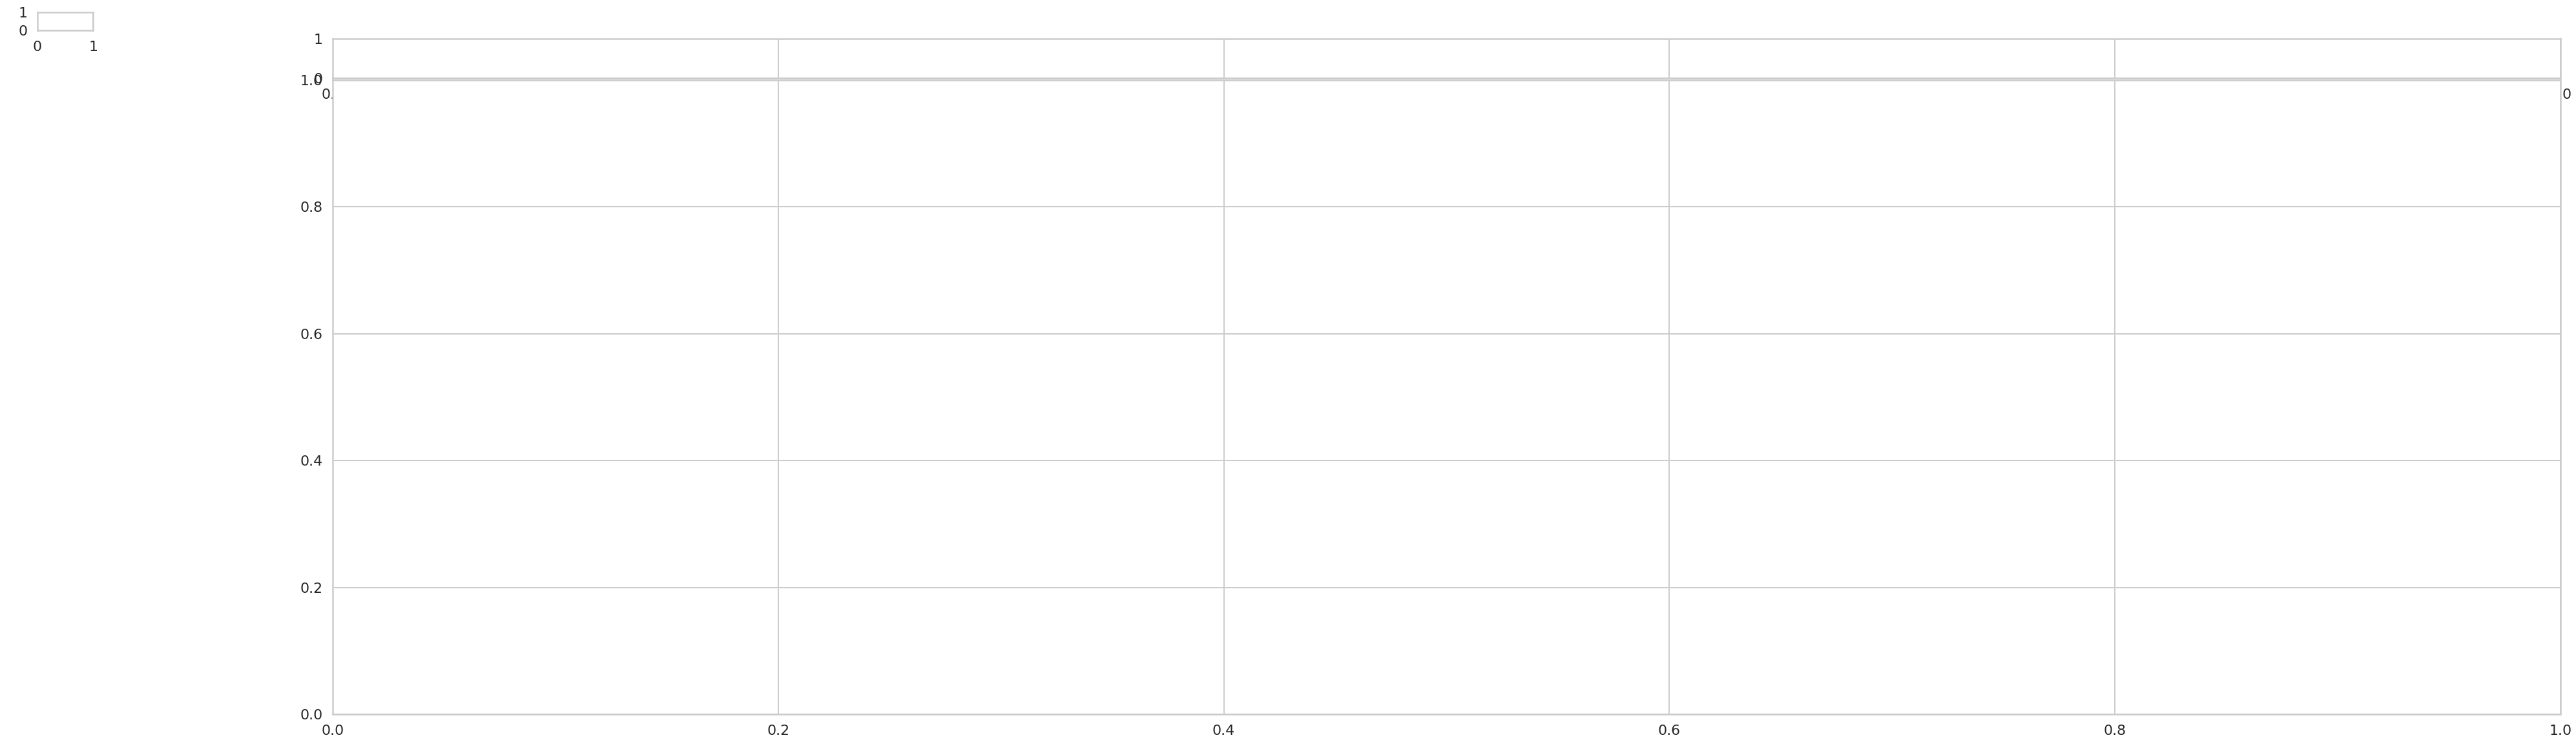

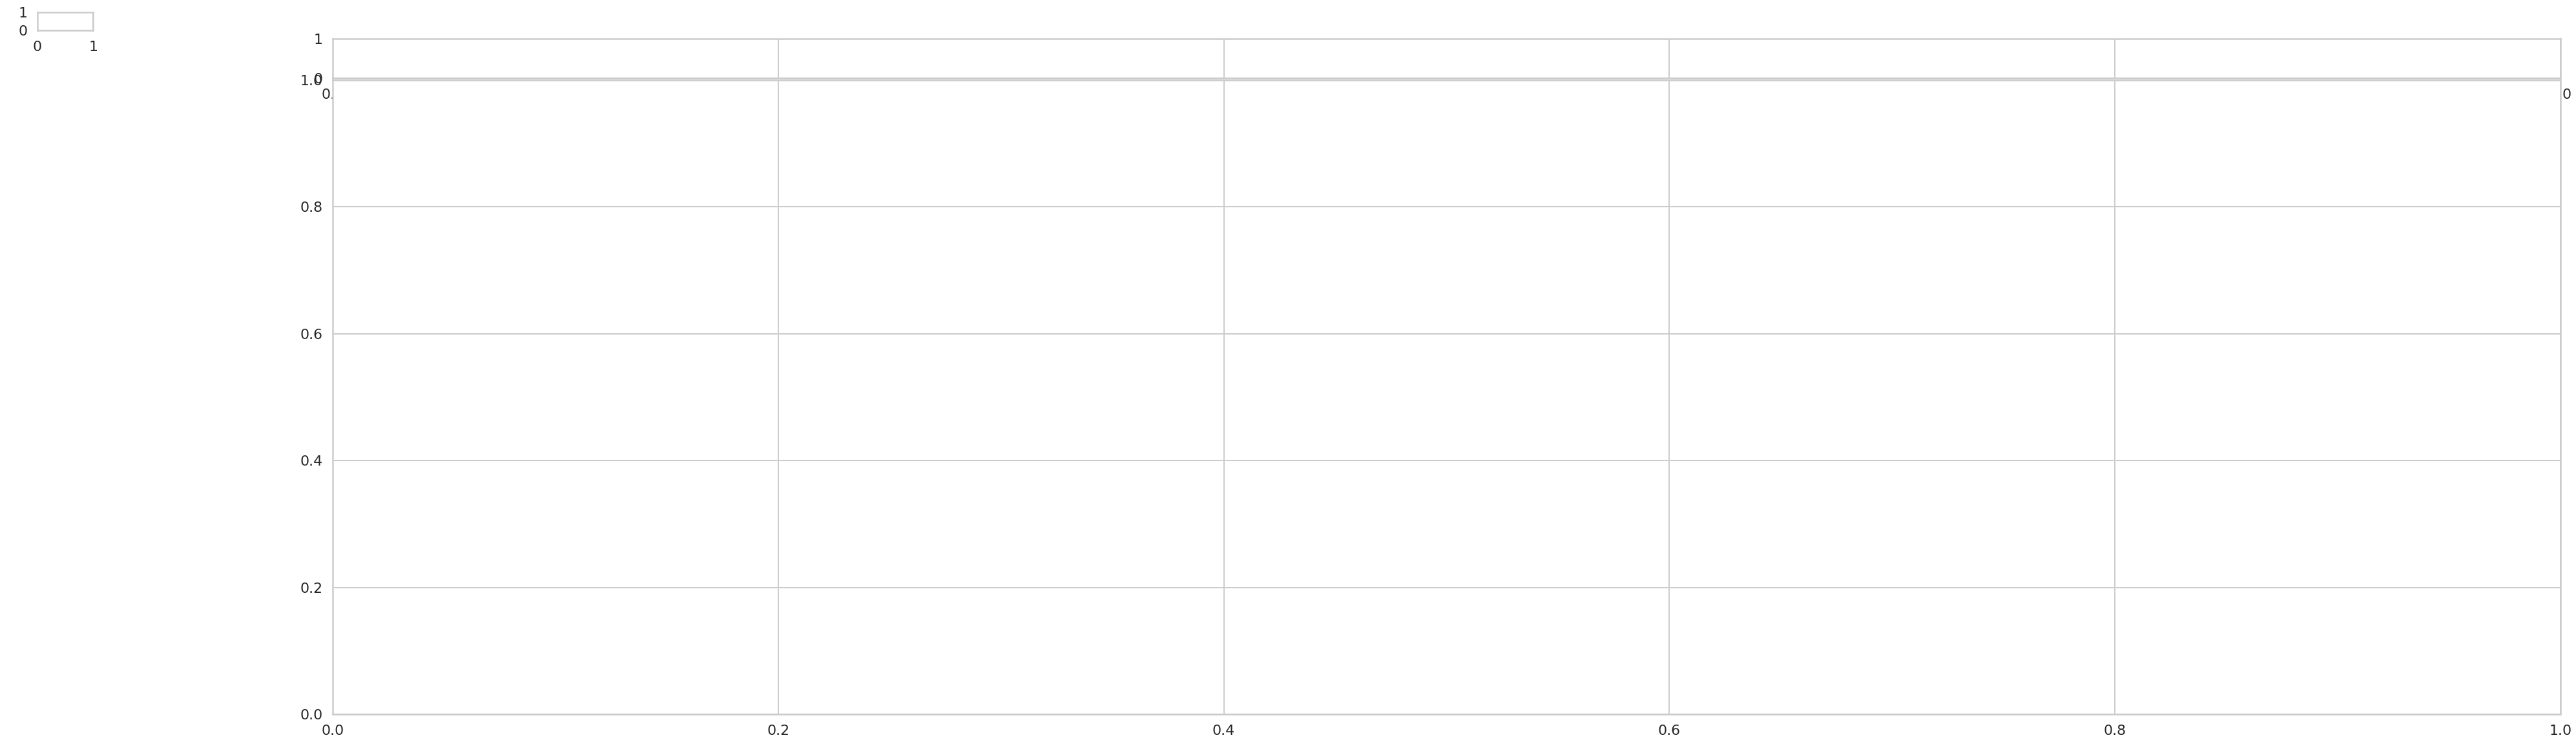

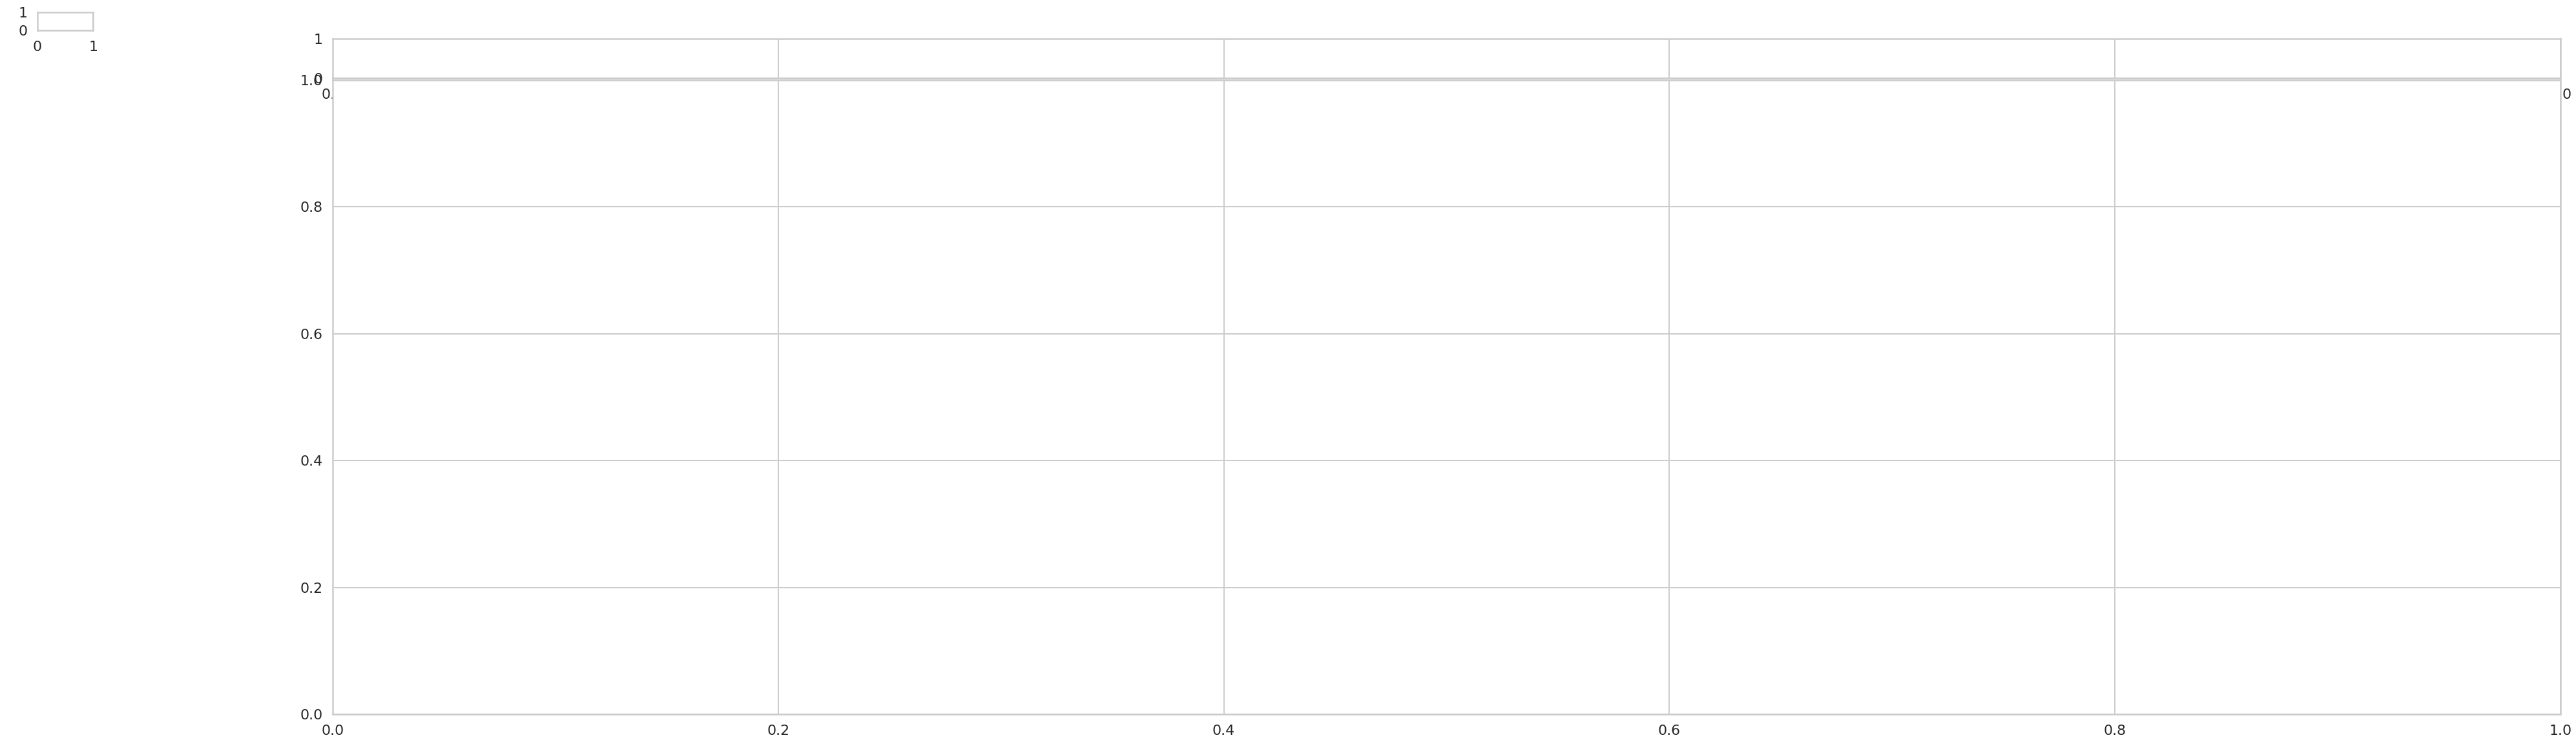

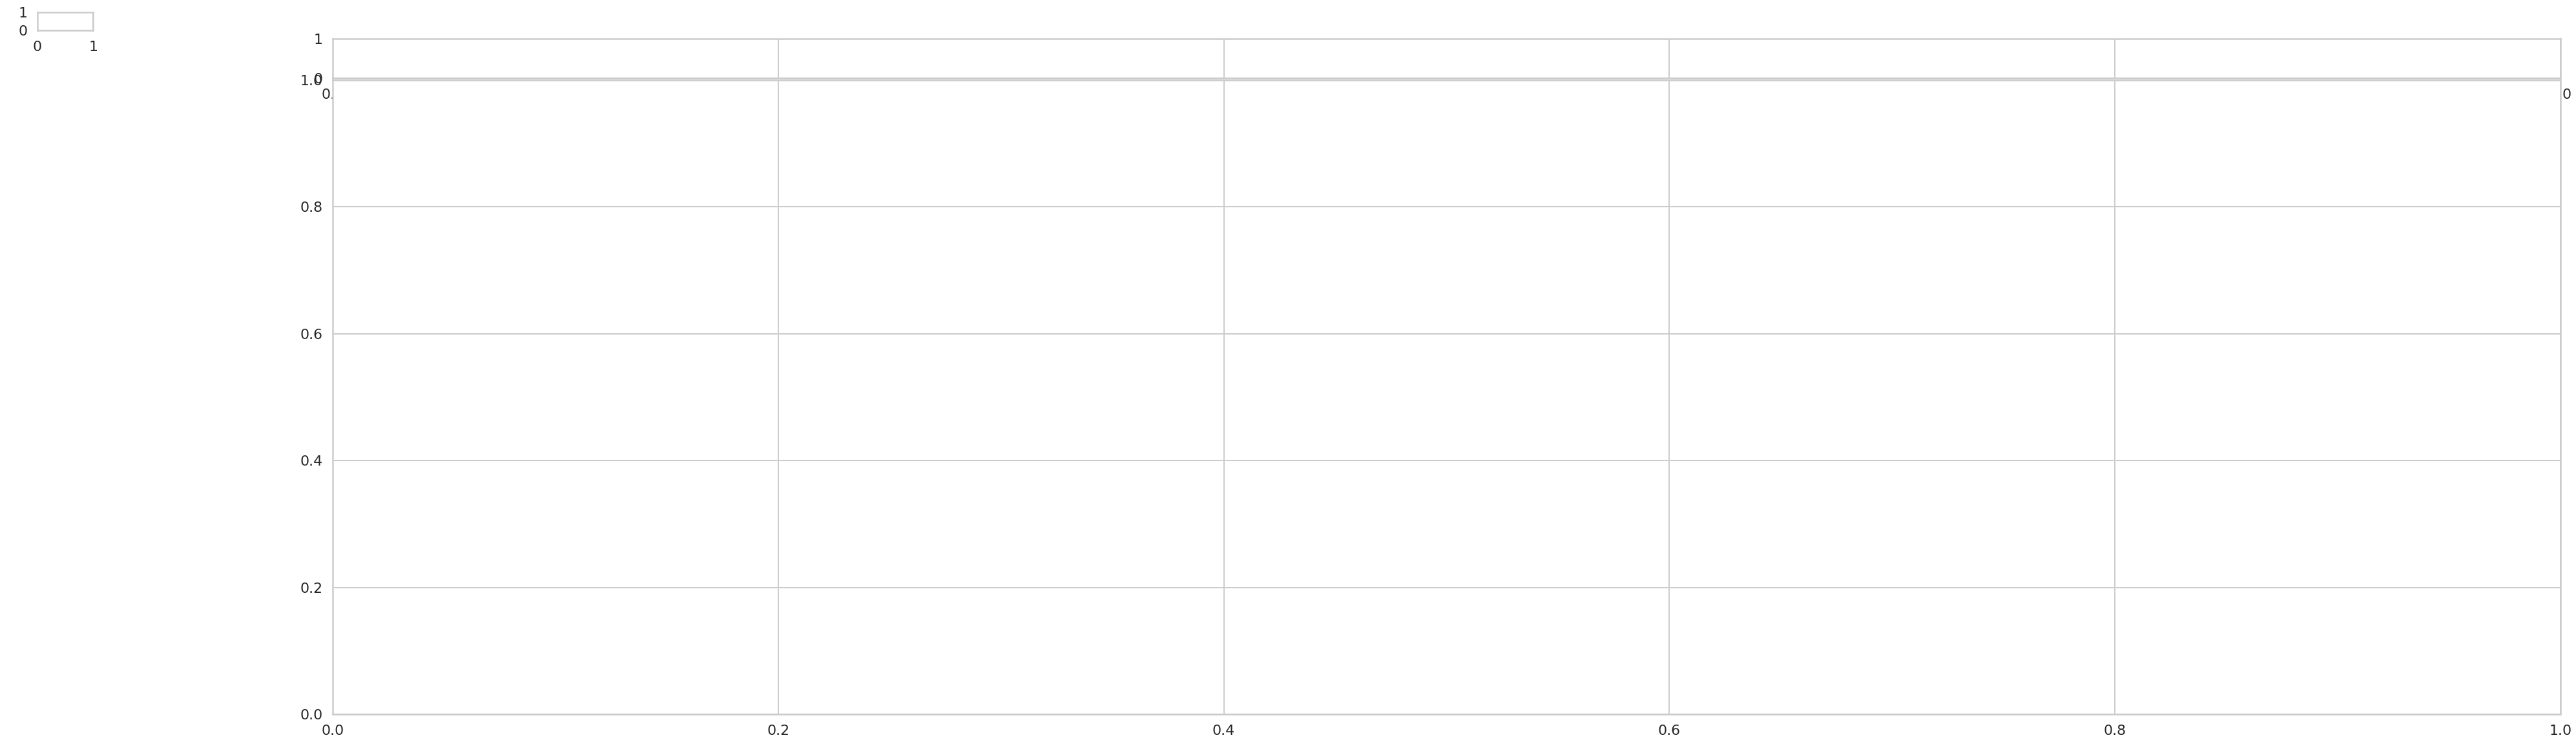

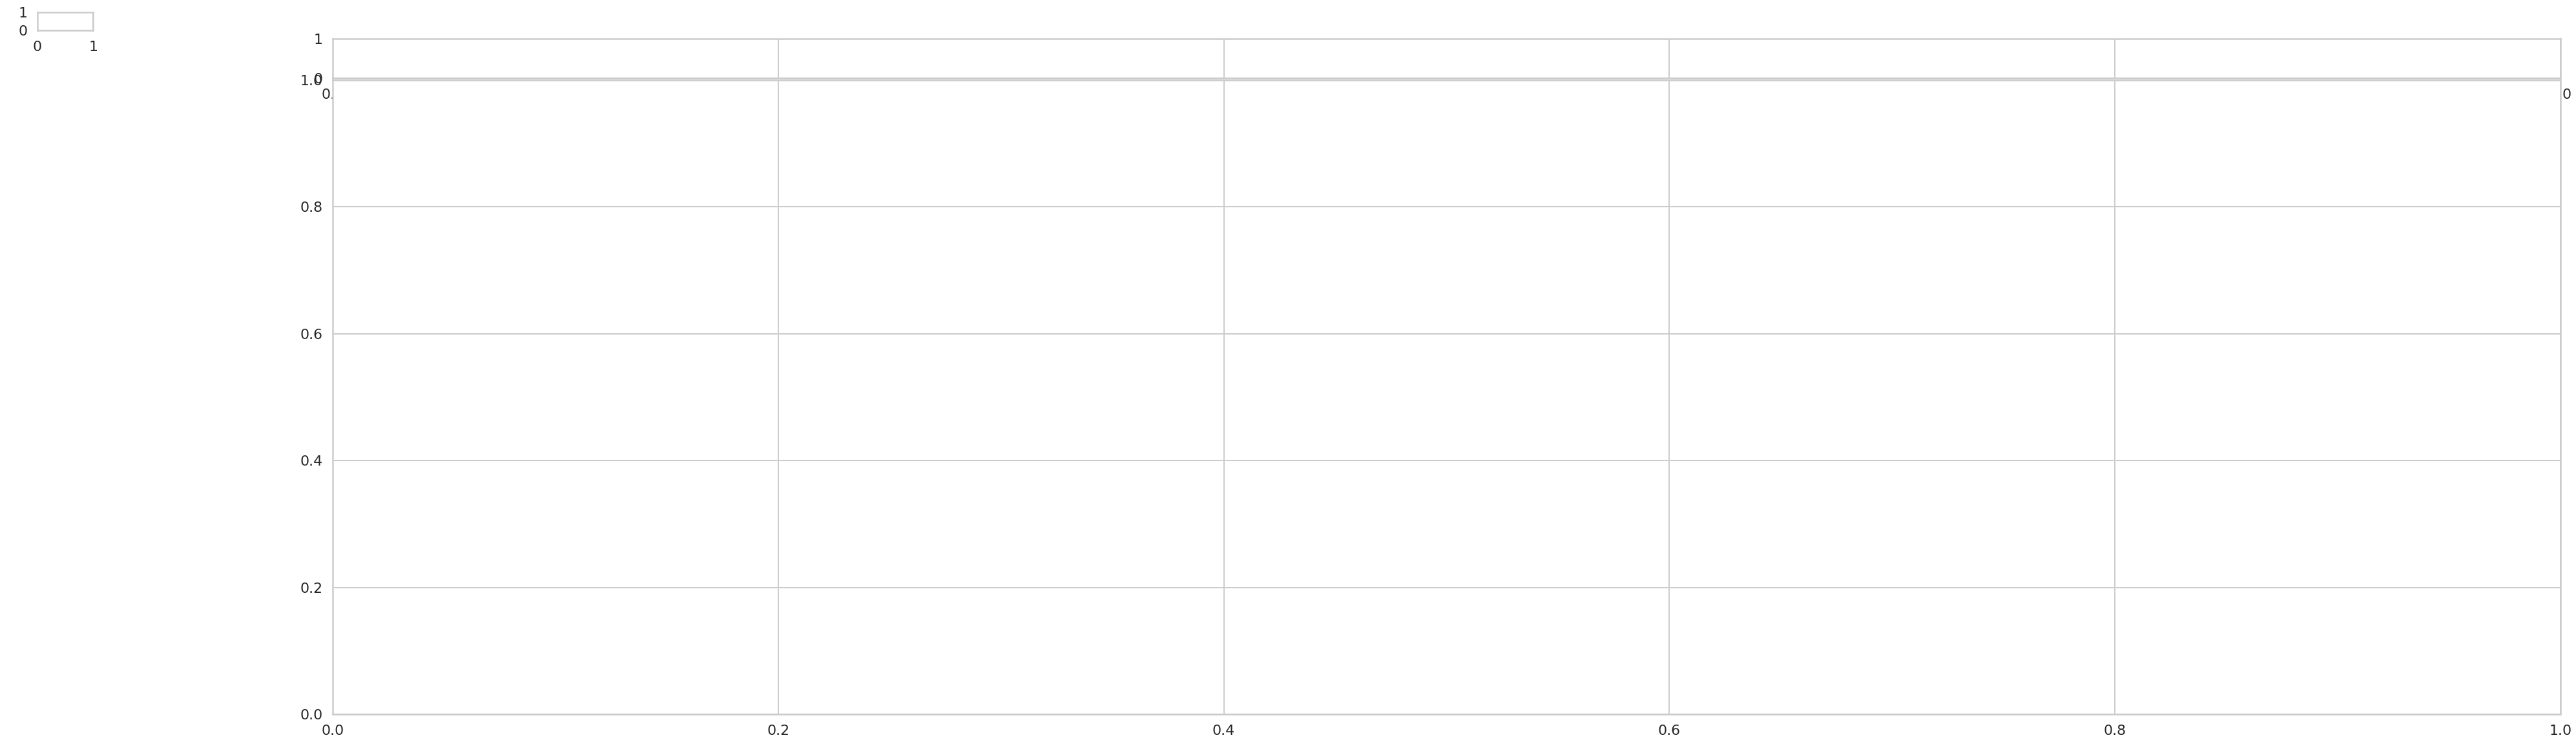

In [41]:
for i in tqdm(root_path[0:6]):
    for j in tqdm(np.array(sample_path)[0:2]):
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/logistic_regression.6.robust.stratified_shuffle_split.png
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/logistic_regression.20.robust.stratified_shuffle_split.png
logistic_regression.9.robust.stratified_shuffle_split
logistic_regression.9.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/logistic_regression.9.robust.stratified_shuffle_split.png
random_forest.9.robust.stratified_shuffle_split
random_forest.9.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/random_forest.9.robust.stratified_shuffle_split.png
logistic_regression.4.robust.stratified_shuffle_split
logistic_regression.4.robust.stratified_s

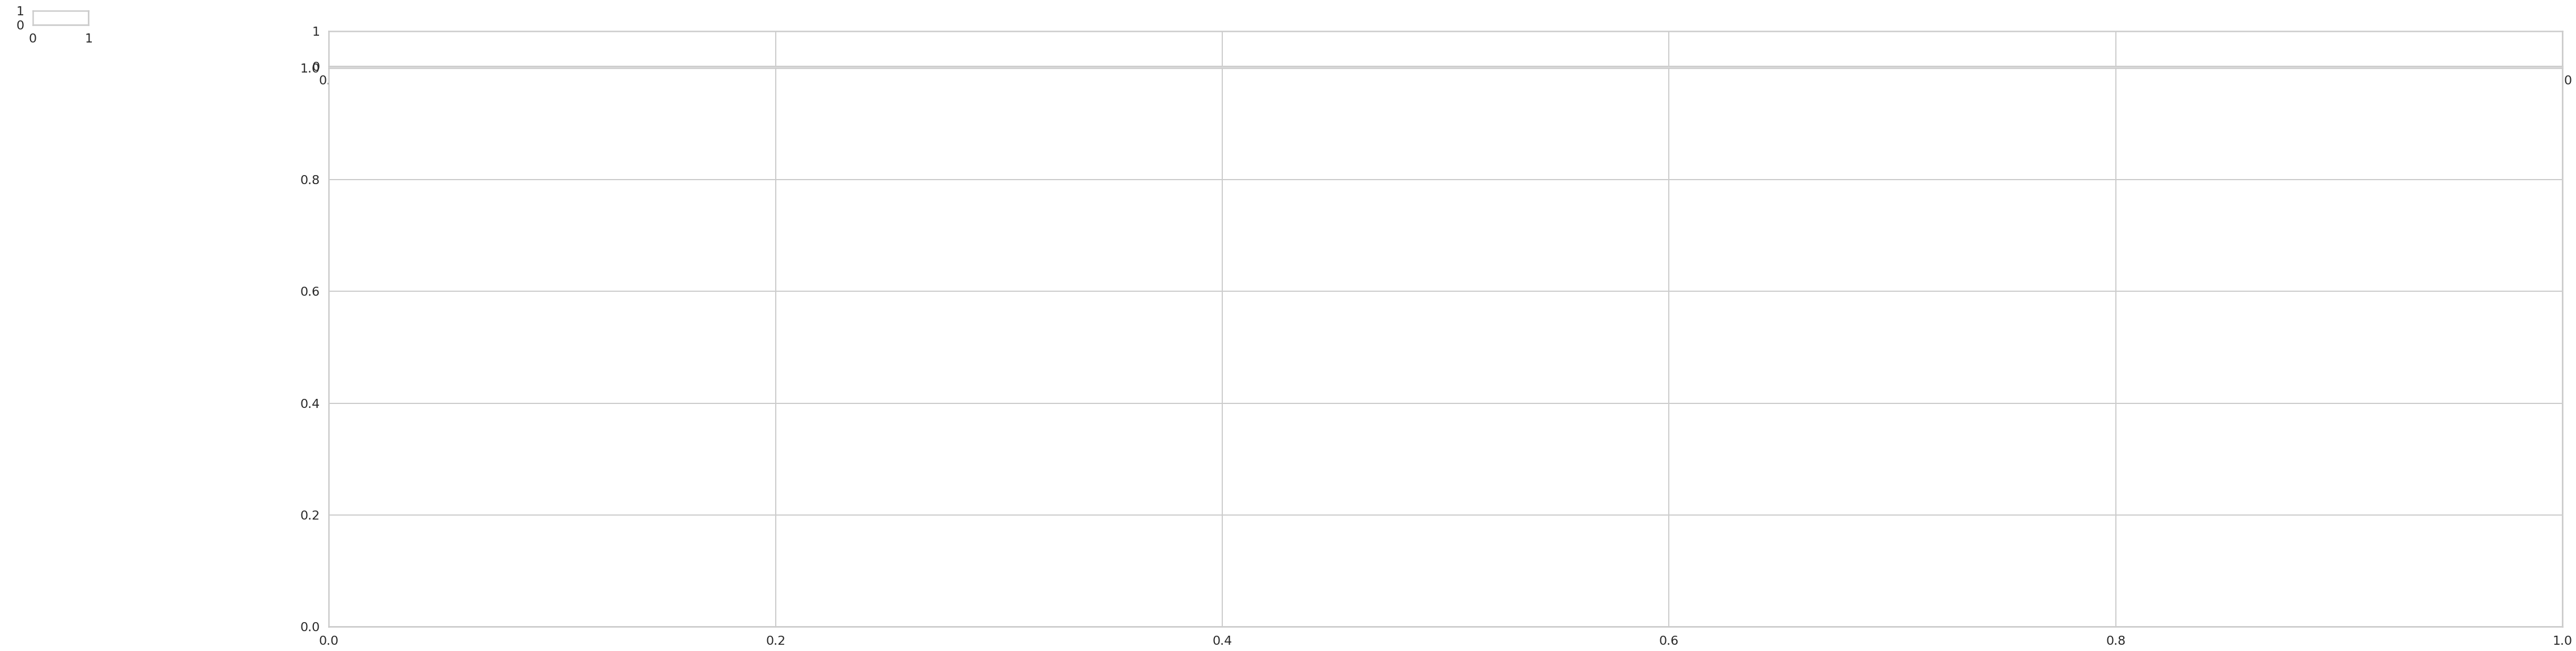

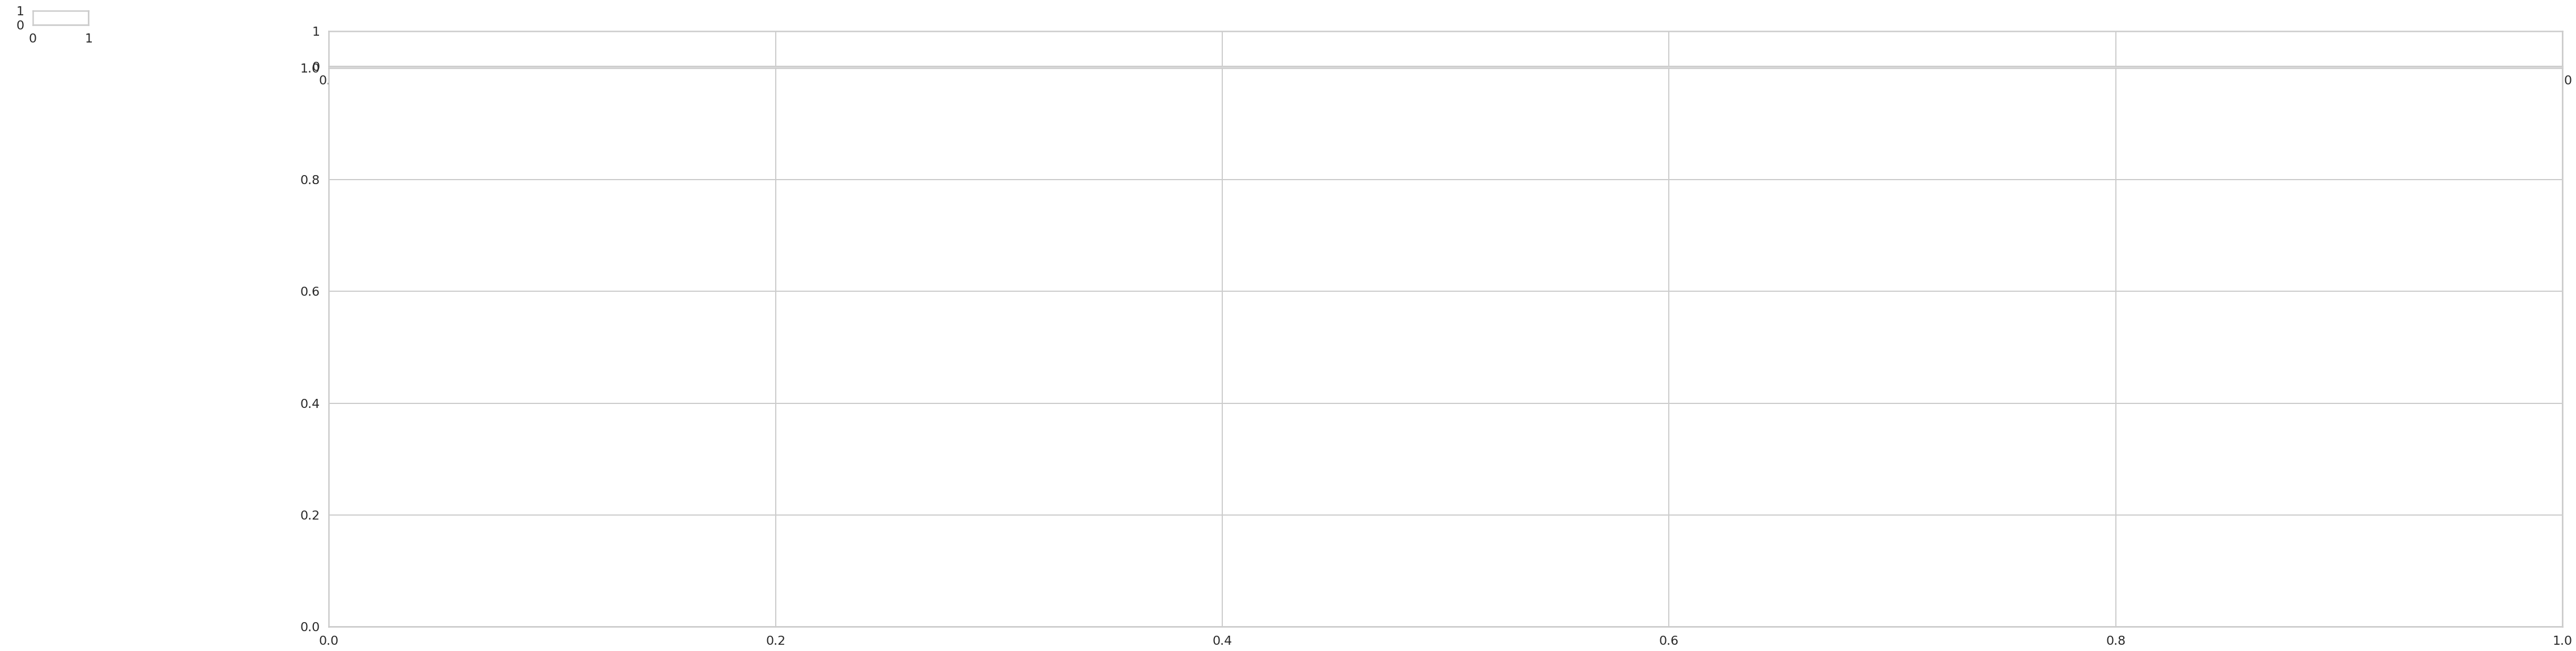

In [72]:
for i in tqdm(root_path[7:8]):
    for j in tqdm(np.array(sample_path)[2:3]):
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

In [45]:
sample_path

['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/']

In [46]:
plot_cluster('/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_ref_normalization/',
            'Normal-CRC/')

logistic_regression.6.robust.stratified_shuffle_split
logistic_regression.6.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/logistic_regression.6.robust.stratified_shuffle_split.png
logistic_regression.6.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/logistic_regression.20.robust.stratified_shuffle_split.png
logistic_regression.20.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
logistic_r

random_forest.7.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
random_forest.1.robust.stratified_shuffle_split
random_forest.1.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/random_forest.1.robust.stratified_shuffle_split.png
random_forest.1.robust.stratified_shuffle_split  file not found
files in the directory:  ['features.txt', '.snakemake_timestamp', 'metrics.stratified_shuffle_split.txt', 'evaluation.stratified_shuffle_split.h5', 'feature_importances.txt', 'best_model.pkl']
random_forest.2.robust.stratified_shuffle_split
random_forest.2.robust.stratified_shuffle_split  file found
data/clustermap/scirep_ref_normalization/Normal-CRC/random_forest.2.robust.stratified_shuffle_split.png
random_forest.2.robust.stratified_shuffle_split  file not foun

In [48]:
root_path[7]

'/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/scirep_ref_normalization/'

In [52]:
root_path[7].split('/')[-2]

'scirep_ref_normalization'

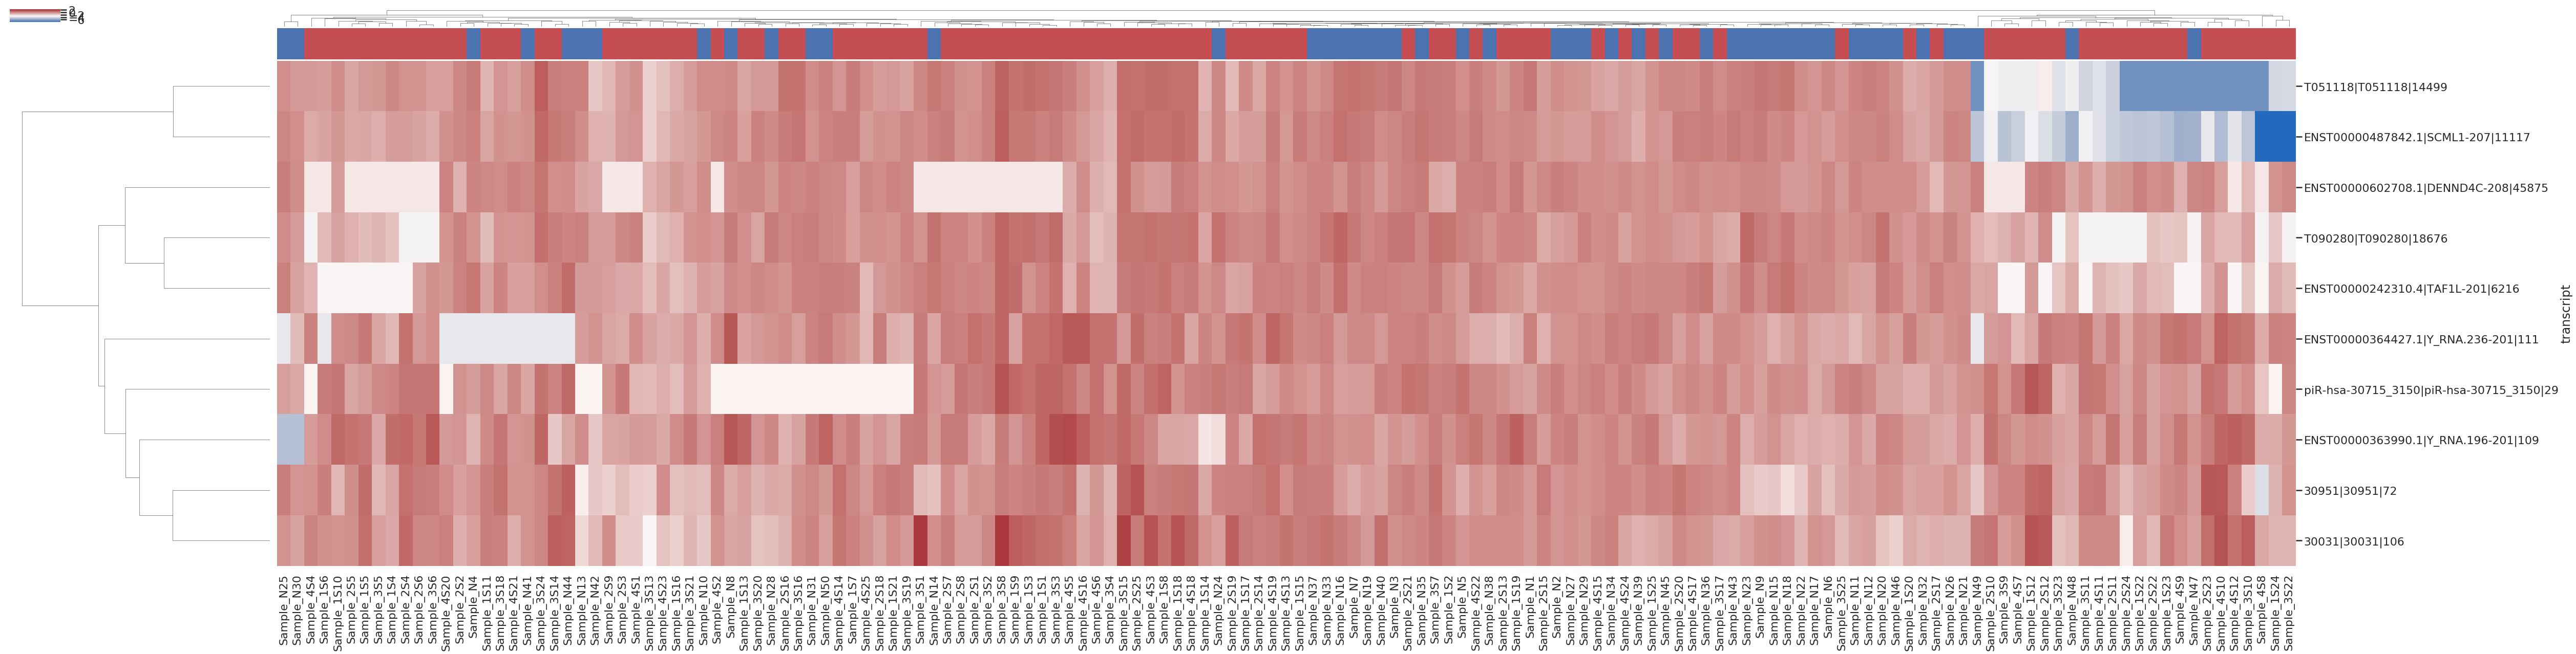

In [71]:
clustermap_crc(root_path[7],'random_forest.10.robust.stratified_shuffle_split/','data/clustermap/'+
              root_path[7].split('/')[-2]+'/'+'Normal-CRC/'+'random_forest.10.robust.stratified_shuffle_split/'
               +'.png',savefigure=False,title=None)

In [54]:
features = pd.read_table(root_path[7]+'Normal-CRC/'+'random_forest.10.robust.stratified_shuffle_split'+'/features.txt', header=None).iloc[:, 0]
    
sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))

In [55]:
m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/scirep_ref_normalization.txt', index_col=0)
#print (features)
cpmtable= m.loc[features,sampless]
cpmmatrix=np.log2(np.array(cpmtable)+1)

In [62]:
np.where(np.isnan(cpmmatrix)==True)[1][0]

76

In [63]:
m.loc[features,sampless].iloc[:,76]

transcript
T051118|T051118|14499                      NaN
T090280|T090280|18676                      NaN
ENST00000602708.1|DENND4C-208|45875        NaN
ENST00000242310.4|TAF1L-201|6216           NaN
ENST00000363990.1|Y_RNA.196-201|109        NaN
30951|30951|72                             NaN
ENST00000364427.1|Y_RNA.236-201|111        NaN
piR-hsa-30715_3150|piR-hsa-30715_3150|29   NaN
ENST00000487842.1|SCML1-207|11117          NaN
30031|30031|106                            NaN
Name: Sample_3S12, dtype: float64